# Phase 0 - Kaggle setup + copy/convert dataset (.webp -> .jpg)

In [1]:
#Import necessary libraries

import numpy as np      # For numerical operations and array handling  
import pandas as pd     # For data manipulation and analysis
import os               # For operating system interface and file operations
import random           # For generating random numbers and setting random seeds
import shutil           # For high-level file operations like copying files
import logging          # For logging information, warnings, and errors
from pathlib import Path   # For object-oriented file system path handling
from typing import Tuple   # For type hints to specify function return types
import tensorflow as tf    # Deep learning framework for GPU configuration
from PIL import Image, UnidentifiedImageError, ImageOps    # Python Imaging Library for image processing

# Configure logging system to display informational messages

logging.basicConfig(level=logging.INFO)                    # Set logging level to INFO
logger = logging.getLogger("Phase0")                       # Create a logger instance named "Phase0"

# Display TensorFlow version for debugging and compatibility checking

print(f"TensorFlow version: {tf.__version__}")            # Print to console
logger.info(f"TensorFlow version: {tf.__version__}")      # Log the information

# Reproducibility

def configure_kaggle_reproducibility(seed: int = 42) -> None:
    random.seed(seed)                                           # Set Python's built-in random seed
    np.random.seed(seed)                                        # Set NumPy's random seed for array operations
    tf.random.set_seed(seed)                                    # Set TensorFlow's random seed for neural network operations
    logger.info(f"Reproducibility configured (seed={seed})")    # Log the configuration
    print(f"Reproducibility configured (seed={seed})")          # Print confirmation

# GPU setup

def setup_kaggle_gpu() -> None:
    gpus = tf.config.experimental.list_physical_devices("GPU")    # Get list of available physical GPU devices
    if gpus:                                                      # If GPU devices are found
        for gpu in gpus:                                          # Iterate through each GPU device
            try:
                tf.config.experimental.set_memory_growth(gpu, True)    # Enable memory growth to allocate GPU memory as needed
            except Exception as e:                                     # Handle any configuration errors
                logger.warning(f"Could not set memory growth: {e}")    # Log warning
        logger.info(f"GPU detected: {gpus[0].name}")                   # Log and print information about the first GPU found
        print(f"GPU detected: {gpus[0].name}")
    else:                                                              # If no GPU devices are found
        logger.warning("No GPU found – running on CPU")                # Log and print warning 
        print("No GPU found – running on CPU")                         # Print 

# file paths

SOURCE_PATH = Path("/kaggle/input/fruit-and-vegetable-disease-healthy-vs-rotten")   # Input dataset path
DEST_PATH   = Path("/kaggle/working/cleaned_dataset")           # Output cleaned dataset path

# Utility function to generate unique file paths

def _unique_path(path: Path) -> Path:
    """Return a non-existing Path by appending _1, _2, ... if needed."""
    if not path.exists():                                       # If the path doesn't exist, return it as-is
        return path
    i = 1                                                       # Counter for generating unique names
    stem, suffix = path.stem, path.suffix                       # Extract filename stem and extension
    while True:                                                 # Loop until a unique path is found
        candidate = path.with_name(f"{stem}_{i}{suffix}")     
        if not candidate.exists():                              # If candidate path doesn't exist
            return candidate                                    # Return the unique path
        i += 1                                                  # Increment counter and try next number

# Utility function to save images in JPEG format with proper orientation

def _save_jpg(img: Image.Image, out_path: Path, quality: int = 95) -> None:
    """Auto-orient, convert to RGB, and save as JPEG."""
    try:                                                        # Auto-rotate image based on EXIF orientation data
        img = ImageOps.exif_transpose(img)
    except Exception:                                           # If EXIF processing fails, continue without rotation
        pass

    # Ensure image is in RGB color mode for JPEG compatibility
    if img.mode not in ("RGB", "L"):
        img = img.convert("RGB")
    elif img.mode == "L":
        img = img.convert("RGB")
    out_path.parent.mkdir(parents=True, exist_ok=True)         # Create output directory if it doesn't exist
    img.save(out_path, format="JPEG", quality=quality, optimize=True, progressive=True)  # Save image as JPEG with specified quality and optimization

# Main function to copy and convert images from source to destination

def copy_and_convert_images(
    src_dir: Path, dest_dir: Path, jpg_quality: int = 95
) -> Tuple[int, int, int, int, int]:
    """
    Copies .jpg/.jpeg/.png as-is, converts .webp -> .jpg.
    Preserves folder structure. Returns counts: total, copied, converted, skipped, errors.
    """
    if not src_dir.exists():                               # Validate that source directory exists
        raise FileNotFoundError(f"Source path does not exist: {src_dir}")
    dest_dir.mkdir(parents=True, exist_ok=True)            # Create destination directory if it doesn't exist

    valid_exts = {".jpg", ".jpeg", ".png", ".webp"}        # Define supported image file extensions
    total = copied = converted = skipped = errors = 0      # Initialize counters for tracking processing results


    #Walk through all files in source directory and subdirectories
    for root, _, files in os.walk(src_dir):   # root: current directory, files: list of files
        for fname in files:                   # Process each file
            total += 1                        # Increment total file counter
            src_path = Path(root) / fname     # Create full source file path
            ext = src_path.suffix.lower()     # Get lowercase file extension
            if ext not in valid_exts:         # Skip files with unsupported extensions
                skipped += 1                  # Increment skipped counter
                continue                      # Move to next file

            rel = src_path.relative_to(src_dir)   # Calculate relative path to preserve directory structure

            try:     # Handle potential errors during file processing
                # Process supported image formats (copy as-is)
                if ext in {".jpg", ".jpeg", ".png"}:
                    dst_path = dest_dir / rel                            # Create destination path
                    dst_path.parent.mkdir(parents=True, exist_ok=True)   # Create parent directories
                    shutil.copy2(src_path, dst_path)                     # Copy file with metadata
                    copied += 1                                          # Increment copied counter

                elif ext == ".webp":     # Process WebP files (convert to JPEG)
                    dst_path = dest_dir / rel.with_suffix(".jpg")       # Change extension to .jpg
                    dst_path = _unique_path(dst_path)                   # Ensure unique filename

                    # Open and process WebP image
                    with Image.open(src_path) as im:                   # Open image file
                        if getattr(im, "is_animated", False):          # Check if animated
                            im.seek(0)                                 # Go to first frame
                        _save_jpg(im, dst_path, quality=jpg_quality)   # Save as JPEG with specified quality
                    converted += 1                                     # Increment converted counter
            # Handle various image processing errors
            except (UnidentifiedImageError, OSError, ValueError) as e:
                errors += 1         # Increment error counter
                logger.warning(f"Failed processing {src_path}: {e}")   # Log the error

    return total, copied, converted, skipped, errors                   # Return all counters as a tuple

# Run Phase 0
print("Starting Phase 0: Kaggle environment setup and dataset preparation")
logger.info("Starting Phase 0")

configure_kaggle_reproducibility()                                     # Configure reproducibility settings
setup_kaggle_gpu()                                                     # Setup GPU configuration
# Execute main image processing function
total, copied, converted, skipped, errors = copy_and_convert_images(SOURCE_PATH, DEST_PATH, jpg_quality=95)

# Sanity check: ensure no .webp remains in cleaned dataset
leftover_webp = list(DEST_PATH.rglob("*.webp"))                             # Search for any remaining .webp files
if leftover_webp:      # If WebP files are found
    logger.warning(f"Leftover .webp files found: {len(leftover_webp)}")     # Log warning
else:                # If no WebP files found
    print("No .webp files remain in cleaned_dataset.")                      # Confirm cleanup

# Display processing results summary
print(f"Total files scanned: {total}")
print(f"Images copied (.jpg/.jpeg/.png): {copied}")
print(f".webp converted to .jpg: {converted}")
print(f"Errors: {errors}")
print(f"Cleaned dataset ready at: {DEST_PATH}")
# Log and print completion message
print("Phase 0 completed successfully.")
logger.info("Phase 0 completed successfully.")


2025-09-07 17:08:50.483949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757264930.827004      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757264930.922178      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow version: 2.18.0
Starting Phase 0: Kaggle environment setup and dataset preparation
Reproducibility configured (seed=42)
GPU detected: /physical_device:GPU:0
No .webp files remain in cleaned_dataset.
Total files scanned: 29291
Images copied (.jpg/.jpeg/.png): 29277
.webp converted to .jpg: 14
Errors: 0
Cleaned dataset ready at: /kaggle/working/cleaned_dataset
Phase 0 completed successfully.


# Phase 1 - Dataset Metadata + Hyperparameters

In [2]:
# Import necessary libraries

import os                         # For operating system interface and file operations
import pandas as pd               # For data manipulation and analysis
from pathlib import Path          # For object-oriented file system path handling
from typing import Dict, Any      # For type hints to specify function parameter and return types
import tensorflow as tf           # For TensorFlow-specific constants like AUTOTUNE

# Define the dataset path - this comes from Phase 0 output
DATASET_PATH = Path("/kaggle/working/cleaned_dataset/")

def load_dataset_metadata(dataset_path: Path) -> pd.DataFrame:
    """
    Walk the dataset folder and build a DataFrame with image paths and class labels.
    Includes only (.jpg/.jpeg/.png).
    """
    data = []                                                  # Initialize empty list to store (filepath, label) tuples
    for root, _, files in os.walk(dataset_path):               # root = current directory, files = list of files
        for file in files:                                     # Iterate through each file in the current directory
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):   # Check if file has a valid image extension 
                full_path = os.path.join(root, file)           # Create full absolute path to the image file
                label = os.path.basename(root)                 # Extract class label from parent directory name
                data.append((full_path, label))                # Add (filepath, label) pair to our data list

     # Convert list of tuples to pandas DataFrame

    df = pd.DataFrame(data, columns=["filepath", "label"])
    # Sanity check: ensure we found images
    if df.empty:
        raise RuntimeError(f"No images found under {dataset_path}. Did Phase 0 finish successfully?")
    # Print dataset statistics for exploratory data analysis (EDA)
    print(f"Total images: {len(df)}")
    print(f"Total classes: {df['label'].nunique()}")
    print("Per-class counts (sorted by name):")
    print(df['label'].value_counts().sort_index())
    return df

def create_class_mapping(df: pd.DataFrame) -> Dict[str, int]:
    """
    Map class names to integer IDs in a stable (sorted) order.
    """
    class_names = sorted(df['label'].unique())       # Get unique class names and sort them alphabetically for reproducibility
    # Create dictionary mapping
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}      # enumerate() gives us (index, value) pairs starting from 0
    print(f"Created class->index mapping for {len(class_names)} classes.")
    return class_to_idx

def define_kaggle_optimized_hyperparameters() -> Dict[str, Any]:
    """
    EfficientNetV2-S optimized hyperparameters for Kaggle GPUs and cross-validation.
    """
    return {
        'dataset_path': str(DATASET_PATH),     # Data paths and configuration  ,  Convert Path to string for compatibility
        'output_path': "/kaggle/working/",     # Data paths and configuration  ,  Where to save models and results
        'image_size': (224, 224, 3),           # Standard input size for EfficientNet
        'batch_size': 32,                      # Batch size - balance between memory usage and training stability
        'epochs_stage1': 15,                   # Stage 1: Train only classifier head,  Frozen backbone training
        'epochs_stage2': 25,                   # Stage 2: Fine-tuning stage
        'learning_rate_stage1': 1e-3,          # Higher LR for frozen backbone
        'learning_rate_stage2': 1e-5,          # Lower LR for fine-tuning
        'dropout_rate': 0.3,                   # Dropout rate
        # Focal Loss parameters (good for imbalanced datasets)
        'focal_loss_alpha': 0.25,              # Weighting factor for rare class vs common class
        'focal_loss_gamma': 2.0,               # Focusing parameter
        'early_stopping_patience': 7,          # Stop training if no improvement for 7 epochs
        'reduce_lr_patience': 4,               # Reduce learning rate if no improvement for 4 epochs
        'test_split': 0.2,                     # 20% for final test set
        'cv_folds': 5,                         # 5-fold cross-validation
        'use_mixed_precision': True,           # Use FP16 to save GPU memory and speed up training
        'cache_preprocessed_data': True,       # Cache preprocessed images in memory for faster training
        'prefetch_buffer_size': tf.data.AUTOTUNE,   # Let TensorFlow optimize data loading pipeline
        'num_parallel_calls': tf.data.AUTOTUNE,     # Parallelize data preprocessing operations
        'shuffle_buffer_size': 1000,                # Buffer size for shuffling training data
        # EfficientNetV2-S specific parameters
        'efficientnetv2_unfreeze_layers': 80,       # Number of layers to unfreeze in stage 2
        'freeze_batch_norm': True,                  # Keep BN frozen during fine-tuning
        'label_smoothing': 0.1                      # For categorical crossentropy
    }

# Run Phase 1
print("Phase 1: Dataset Metadata Analysis for EfficientNetV2-S")
df = load_dataset_metadata(DATASET_PATH)                  # Load and analyze dataset structure
class_to_idx = create_class_mapping(df)                   # Create class-to-index mapping
hyperparams = define_kaggle_optimized_hyperparameters()   # Define training hyperparameters
print("Phase 1 completed.")


Phase 1: Dataset Metadata Analysis for EfficientNetV2-S
Total images: 29284
Total classes: 28
Per-class counts (sorted by name):
label
Apple__Healthy          2438
Apple__Rotten           2930
Banana__Healthy         1999
Banana__Rotten          2797
Bellpepper__Healthy      611
Bellpepper__Rotten       591
Carrot__Healthy          620
Carrot__Rotten           579
Cucumber__Healthy        608
Cucumber__Rotten         593
Grape__Healthy           200
Grape__Rotten            200
Guava__Healthy           200
Guava__Rotten            200
Jujube__Healthy          200
Jujube__Rotten           200
Mango__Healthy          1813
Mango__Rotten           2247
Orange__Healthy         2075
Orange__Rotten          2186
Pomegranate__Healthy     200
Pomegranate__Rotten      200
Potato__Healthy          615
Potato__Rotten           584
Strawberry__Healthy     1603
Strawberry__Rotten      1596
Tomato__Healthy          604
Tomato__Rotten           595
Name: count, dtype: int64
Created class->index mappin

# Phase 2 - EDA (Essential Analysis Only)

Phase 2: Starting EDA for EfficientNetV2-S...
Total images: 29284
Total classes: 28

Per-class counts:
label
Apple__Healthy          2438
Apple__Rotten           2930
Banana__Healthy         1999
Banana__Rotten          2797
Bellpepper__Healthy      611
Bellpepper__Rotten       591
Carrot__Healthy          620
Carrot__Rotten           579
Cucumber__Healthy        608
Cucumber__Rotten         593
Grape__Healthy           200
Grape__Rotten            200
Guava__Healthy           200
Guava__Rotten            200
Jujube__Healthy          200
Jujube__Rotten           200
Mango__Healthy          1813
Mango__Rotten           2247
Orange__Healthy         2075
Orange__Rotten          2186
Pomegranate__Healthy     200
Pomegranate__Rotten      200
Potato__Healthy          615
Potato__Rotten           584
Strawberry__Healthy     1603
Strawberry__Rotten      1596
Tomato__Healthy          604
Tomato__Rotten           595
Name: count, dtype: int64


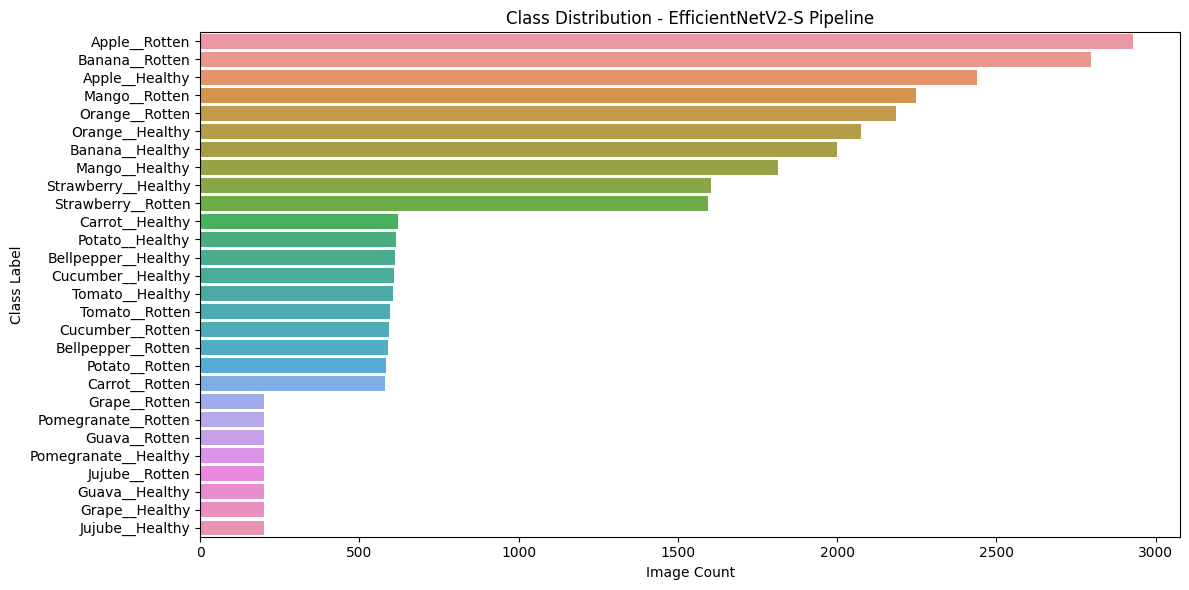

Phase 2 completed.


In [3]:
# Import libraries

import matplotlib.pyplot as plt  # Primary plotting library for creating figures and charts
import seaborn as sns            # Statistical data visualization library built on matplotlib 

# Dataset path from our cleaned dataset (output of Phase 0)
DATASET_PATH = Path("/kaggle/working/cleaned_dataset/")

def get_image_dataframe(dataset_path: Path) -> pd.DataFrame:
    data = []                                                 # Initialize empty list to collect (filepath, label)
    for root, _, files in os.walk(dataset_path):              # root = current directory path
        for file in files:                                    # Process each file in current directory
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):   # Filter for common image file extensions
                full_path = os.path.join(root, file)          # Construct full absolute path to the image file
                label = os.path.basename(root)                # Extract class label from parent directory name
                data.append((full_path, label))               # Store filepath and label as tuple in our data collection
    df = pd.DataFrame(data, columns=["filepath", "label"])    # Convert collected data into pandas DataFrame
    if df.empty:       # Validation check
        raise RuntimeError(f"No images found under {dataset_path}. Did Phase 0 run?")
     # Print basic dataset statistics for initial overview
    print(f"Total images: {len(df)}")
    print(f"Total classes: {df['label'].nunique()}")
    return df

def plot_class_distribution(df: pd.DataFrame):
    plt.figure(figsize=(12, 6))                               # Create a new figure with specified size 
    sns.countplot(y='label', data=df, order=df['label'].value_counts().index)   # Create horizontal countplot using seaborn
    plt.title("Class Distribution - EfficientNetV2-S Pipeline")   # Add descriptive title indicating this is for EfficientNetV2-S pipeline
    plt.xlabel("Image Count")                                # X-axis shows the number of images per class
    plt.ylabel("Class Label")                                # Y-axis shows the class names
    plt.tight_layout()                                       # Adjust layout to prevent label cutoff and improve readability
    plt.show()                                               # Display the plot in the notebook/console output
    plt.close()                                              # Close the figure to free memory

# Run Phase 2
print("Phase 2: Starting EDA for EfficientNetV2-S...")
df_images = get_image_dataframe(DATASET_PATH)                # Load dataset metadata into DataFrame for analysis
print("\nPer-class counts:")
print(df_images['label'].value_counts().sort_index())

plot_class_distribution(df_images)                          # Create visual representation of class distribution
print("Phase 2 completed.")


# Phase 3 - Cross-Validation Splits (Enhanced from original)

In [4]:
# Import scikit-learn's splitting utilities 
from sklearn.model_selection import train_test_split, StratifiedKFold

# Paths - Create output directory for storing split information
OUTPUT_SPLIT_DIR = Path("/kaggle/working/splits/")    # Directory to save split metadata
OUTPUT_SPLIT_DIR.mkdir(parents=True, exist_ok=True)   # Create directory if it doesn't exist

# Import splitting parameters from hyperparameters defined in Phase 1
TEST_SIZE = hyperparams['test_split']                 # Proportion of data for final testing (0.2 = 20%)
CV_FOLDS = hyperparams['cv_folds']                    # Number of cross-validation folds (5-fold CV)
SEED = 42                                             # Random seed for reproducible splits across experiments

def get_image_class_dataframe(dataset_path: Path) -> pd.DataFrame:
    data = []                                         # Initialize list to collect image metadata
    # Recursively traverse dataset directory structure
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(root, file)
                label = os.path.basename(root)
                data.append((full_path, label))
    df = pd.DataFrame(data, columns=["filepath", "label"])    # Convert to pandas DataFrame 
    if df.empty:                                              # Validation: ensure dataset was loaded successfully
        raise RuntimeError(f"No images found under {dataset_path}. Did Phase 0 run?")
    # This ensures identical splits across different script executions
    df = df.sort_values("filepath").reset_index(drop=True)
    print(f"Found {len(df)} images in {df['label'].nunique()} classes")  # Display dataset statistics for verification
    return df

def create_cv_splits_with_test(df: pd.DataFrame) -> Dict[str, Any]:
    """
    Create: 1) Final test set (20%), 2) Cross-validation splits on remaining 80%
    """
    # Check if we have sufficient samples per class for stratified K-fold CV
    class_counts = df['label'].value_counts()      # Count samples per class
    min_samples = class_counts.min()               # Find the smallest class

    # For stratified K-fold CV, each fold needs at least 1 sample per class
    if min_samples < CV_FOLDS + 1:
        raise ValueError(f"Insufficient samples for {CV_FOLDS}-fold CV. "
                        f"Minimum class has {min_samples} samples, need at least {CV_FOLDS + 1}")
    
    print(f"Creating {CV_FOLDS}-fold CV with {TEST_SIZE:.0%} test holdout for EfficientNetV2-S...")
    
    # Split dataset into training+validation (80%) and final test set (20%)
    df_train_val, df_test = train_test_split(
        df,          # Full dataset
        test_size=TEST_SIZE,      # Proportion for test set (0.2 = 20%)
        stratify=df['label'],     # Maintain class proportions in both splits
        random_state=SEED,        # For reproducible splits
        shuffle=True              # Randomly shuffle before splitting
    )
    
    # Display split statistics for verification
    print(f"Final test set: {len(df_test)} images ({len(df_test)/len(df):.1%})")
    print(f"Train+Val set: {len(df_train_val)} images ({len(df_train_val)/len(df):.1%})")
    
    # Create K-fold splits on train_val data
    skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=SEED)
    cv_splits = []

     # Create each fold by splitting train_val data
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(df_train_val, df_train_val['label'])):
        train_data = df_train_val.iloc[train_idx].reset_index(drop=True)   # Extract training data for current fold
        val_data = df_train_val.iloc[val_idx].reset_index(drop=True)       # Extract validation data for current fold

        # Store fold information in structured format
        cv_splits.append({
            'fold': fold_idx,           # Fold number (0-indexed)
            'train': train_data,        # Training samples for this fold
            'val': val_data             # Validation samples for this fold
        })
        
        print(f"Fold {fold_idx + 1}: Train={len(train_data)}, Val={len(val_data)}")  # Display fold statistics for verification
    
    return {
        'test_set': df_test.reset_index(drop=True),  # Final test set
        'cv_splits': cv_splits,                      # All cross-validation folds for model training
        # Metadata for documentation and verification
        'metadata': {
            'total_samples': len(df),            # Total number of images
            'test_samples': len(df_test),        # Number of test images
            'cv_samples': len(df_train_val),     # Number of train+val images
            'num_folds': CV_FOLDS,               # Number of CV folds
            'num_classes': df['label'].nunique(),          # Number of unique classes
            'class_names': sorted(df['label'].unique())    # List of all class names
        }
    }

# Run Phase 3
print("Phase 3: Starting cross-validation dataset split for EfficientNetV2-S")
df_all = get_image_class_dataframe(DATASET_PATH)   # Load complete dataset with class labels
splits_data = create_cv_splits_with_test(df_all)   # Create comprehensive data splits (test set + CV folds)

# Save test set for final evaluation
test_csv_path = OUTPUT_SPLIT_DIR / "test_split.csv"           # Define output path
splits_data['test_set'].to_csv(test_csv_path, index=False)    # Save as CSV file
print(f"Test set saved to: {test_csv_path}")                  # Confirm successful save

print("Phase 3 completed successfully.")


Phase 3: Starting cross-validation dataset split for EfficientNetV2-S
Found 29284 images in 28 classes
Creating 5-fold CV with 20% test holdout for EfficientNetV2-S...
Final test set: 5857 images (20.0%)
Train+Val set: 23427 images (80.0%)
Fold 1: Train=18741, Val=4686
Fold 2: Train=18741, Val=4686
Fold 3: Train=18742, Val=4685
Fold 4: Train=18742, Val=4685
Fold 5: Train=18742, Val=4685
Test set saved to: /kaggle/working/splits/test_split.csv
Phase 3 completed successfully.


# Phase 4 - tf.data pipeline (Cross-validation ready)

In [5]:
# Import necessary libraries
import json      # For JSON serialization (if needed for metadata storage)
import tensorflow as tf        
from tensorflow.keras import layers

# Extract key training parameters from hyperparameters defined in Phase 1
BATCH_SIZE = hyperparams['batch_size']        # Number of samples processed simultaneously (32)
IMAGE_SIZE = hyperparams['image_size'][:2]    # Target image dimensions (224, 224)
AUTOTUNE = tf.data.AUTOTUNE                   # Let TensorFlow optimize pipeline performance automatically

# Create stable class mapping from all data
def build_class_mapping(class_names):
    """Build stable class mapping with TensorFlow lookup table"""
    class_to_idx = {name: idx for idx, name in enumerate(sorted(class_names))}     # Create deterministic class-to-index mapping 
    idx_to_class = [name for name, _ in sorted(class_to_idx.items(), key=lambda x: x[1])]   # Create reverse mapping for converting model predictions back to class names
    
    # Create TensorFlow lookup table
    keys_tensor = tf.constant(list(class_to_idx.keys()))                           # Class names as strings
    vals_tensor = tf.constant(list(class_to_idx.values()), dtype=tf.int64)
    table_init = tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor)     # Initialize lookup table with key-value pairs
    lookup_table = tf.lookup.StaticHashTable(table_init, default_value=-1)         # Create static hash table for fast lookups during training
    
    return {
        'class_to_idx': class_to_idx,      # Python dict: class_name -> integer
        'idx_to_class': idx_to_class,      # Python list: index -> class_name
        'lookup_table': lookup_table,      # TensorFlow lookup table for efficient conversion
        'num_classes': len(class_names)    # Total number of classes
    }

# Build class mapping
class_mapping = build_class_mapping(splits_data['metadata']['class_names'])
NUM_CLASSES = class_mapping['num_classes']  # Extract number of classes for model architecture

@tf.function     # Decorator to compile function into TensorFlow graph for faster execution
def decode_image(filename: tf.Tensor, label_str: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    """
    Decode image for EfficientNetV2-S pipeline.
    Returns images in [0,1] range for compatibility with efficientnet_v2.preprocess_input.
    """
    img_raw = tf.io.read_file(filename)    # Read raw image data from file system
    
    ext = tf.strings.lower(tf.strings.split(filename, '.')[-1]) # Extract file extension to determine decoding method

    # Define decoding functions for different image formats
    def decode_jpeg():
        return tf.image.decode_jpeg(img_raw, channels=3)
    
    def decode_png():
        return tf.image.decode_png(img_raw, channels=3)
      # Conditional decoding based on file extension
    img = tf.cond(
        tf.logical_or(tf.equal(ext, 'jpg'), tf.equal(ext, 'jpeg')),  # If JPEG format
        decode_jpeg,         # Use JPEG decoder
        decode_png           # Otherwise use PNG decoder
    )
    
    img.set_shape([None, None, 3])               # Set explicit shape for tensor 
    img = tf.image.resize(img, IMAGE_SIZE, method=tf.image.ResizeMethod.BILINEAR)   # Resize image to target dimensions
    img = tf.clip_by_value(img, 0, 255)          # Ensure pixel values are within valid range [0, 255]
    img = tf.cast(img, tf.float32) / 255.0       # [0,1] range for EfficientNetV2 preprocessing

    # Convert label string to one-hot encoding
    label_id = class_mapping['lookup_table'].lookup(label_str)             # Convert string label to integer index using lookup table
    label_id = tf.where(label_id < 0, tf.zeros_like(label_id), label_id)   # Handle potential lookup failures (shouldn't happen with clean data)
    one_hot = tf.one_hot(label_id, depth=NUM_CLASSES)                      # Convert integer label to one-hot encoded vector
    return img, one_hot

@tf.function   # Compile for faster execution during training
def augment_image(image: tf.Tensor, label: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
    """Data augmentation for EfficientNetV2-S training"""
    image = tf.image.random_flip_left_right(image)             # Random horizontal flip - simulates different viewing angles
    image = tf.image.random_brightness(image, max_delta=0.1)   # Random brightness adjustment 
    image = tf.image.random_contrast(image, 0.9, 1.1)          # Random contrast adjustment
    return image, label

def build_dataset(df: pd.DataFrame, is_training: bool = True) -> tf.data.Dataset:
    """Build tf.data.Dataset from DataFrame for EfficientNetV2-S"""
    filepaths = df['filepath'].values                         # Image file paths
    labels = df['label'].values                               # Corresponding class labels

    # Create TensorFlow dataset from numpy arrays
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))
     
    if is_training:
        ds = ds.shuffle(hyperparams['shuffle_buffer_size'], reshuffle_each_iteration=True) # Shuffle dataset for better gradient updates and generalization
    # Apply image decoding and preprocessing in parallel
    ds = ds.map(decode_image, num_parallel_calls=AUTOTUNE)
    
    if is_training:
        ds = ds.map(augment_image, num_parallel_calls=AUTOTUNE)  # Apply data augmentation only during training (not validation/test)
    
    ds = ds.batch(BATCH_SIZE, drop_remainder=False)              # Group samples into batches for efficient GPU processing
    ds = ds.apply(tf.data.experimental.ignore_errors())          # Handle potential errors
    ds = ds.prefetch(AUTOTUNE)                                   # Prefetch next batch while current batch is being processed
    return ds

def get_class_names():
    return class_mapping['idx_to_class']

print("Phase 4: tf.data pipeline ready for EfficientNetV2-S cross-validation")
print(f"Number of classes: {NUM_CLASSES}")
print("Phase 4 completed.")


Phase 4: tf.data pipeline ready for EfficientNetV2-S cross-validation
Number of classes: 28
Phase 4 completed.


I0000 00:00:1756405120.285212      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756405120.285935      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Phase 5 - EfficientNetV2-S model builder

In [6]:
# Import TensorFlow/Keras modules for model construction

from tensorflow.keras import layers, models

def create_efficientnetv2s_model(
    input_shape=(224, 224, 3),            # Input image dimensions (height, width, channels)
    num_classes: int = 28,                # Number of output classes for classification
    dropout_rate: float = 0.3,             # Dropout probability for regularization
    *,                                     # Force keyword-only arguments below 
    trainable_backbone: bool = True,      # Whether backbone layers can be trained
    fine_tune_at: int | None = None,      # freeze layers BEFORE this index
    unfreeze_last_n: int | None = None,   # or unfreeze last N layers
    freeze_batch_norm: bool = True        # keep BN frozen during fine-tune
) -> tf.keras.Model:
    """
    EfficientNetV2-S model builder with fine-tuning controls.
    Works with Phase 4 pipeline (inputs in [0,1]).
    Adds efficientnet_v2.preprocess_input so the backbone sees expected distribution.
    """
    inputs = layers.Input(shape=input_shape, name="input_image")  # Define input layer with explicit shape for the model
    
    # EfficientNetV2 preprocessing
    x = layers.Lambda(tf.keras.applications.efficientnet_v2.preprocess_input,
                      name="effv2_preproc")(inputs)             # This converts [0,1] range inputs to the expected distribution for pretrained weights

    # EfficientNetV2-S backbone
    base = tf.keras.applications.EfficientNetV2S(
        input_shape=input_shape,    # Input dimensions (224x224x3 standard)
        include_top=False,          # Remove original classification head 
        weights="imagenet",         # Use pretrained ImageNet weights 
    )
    base._name = "efficientnetv2s_base"    # Rename backbone for better model visualization and debugging
    base.trainable = trainable_backbone    # Set initial trainability of backbone 

    # Fine-tuning policy
    if trainable_backbone: # Only apply fine-tuning controls if backbone is trainable
        if unfreeze_last_n is not None:                     # Unfreeze last N layers approach
            # Freeze all layers, then unfreeze last N
            for layer in base.layers:                       # First, freeze ALL layers in the backbone
                layer.trainable = False
            for layer in base.layers[-unfreeze_last_n:]:    # Then, unfreeze only the last N layers for fine-tuning
                layer.trainable = True
        elif fine_tune_at is not None:                      # Fine-tune from specific layer index
            # Freeze layers before fine_tune_at index
            for layer in base.layers[:fine_tune_at]:
                layer.trainable = False

        # Always freeze BatchNormalization layers during fine-tuning
        if freeze_batch_norm:
            for layer in base.layers:
                if isinstance(layer, layers.BatchNormalization):
                    layer.trainable = False

    # Classification head
    x = base(x) # Apply the backbone to preprocessed input
    x = layers.GlobalAveragePooling2D(name="gap")(x)                                   # Global Average Pooling 2D - Convert feature maps to single vector
    x = layers.Dropout(dropout_rate, name="dropout")(x)                                # Dropout layer for regularization
    outputs = layers.Dense(num_classes, activation="softmax", name="predictions")(x)   # Dense layer with softmax activation for multi-class classification

    model = models.Model(inputs, outputs, name="efficientnetv2s_finetune")             # Create the complete model by connecting inputs to outputs
    return model

print("Phase 5: EfficientNetV2-S model builder ready")
print("Phase 5 completed.")



Phase 5: EfficientNetV2-S model builder ready
Phase 5 completed.


# Phase 6 - Cross-Validation Training (EfficientNetV2-S Two-Stage)

In [7]:
# Import necessary Keras components for training callbacks and loss functions
from tensorflow.keras import callbacks
from tensorflow.keras.losses import CategoricalCrossentropy

# Enable mixed precision if configured
if hyperparams.get('use_mixed_precision', True):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled (float16) for EfficientNetV2-S.")

# Pull hyperparams
EPOCHS1 = hyperparams['epochs_stage1']                      # Number of epochs for frozen training (15)
EPOCHS2 = hyperparams['epochs_stage2']                      # Number of epochs for fine-tuning (25)
LR1 = hyperparams['learning_rate_stage1']                   # Learning rate for stage 1 (1e-3, higher)
LR2 = hyperparams['learning_rate_stage2']                   # Learning rate for stage 2 (1e-5, lower)
DROPOUT = hyperparams['dropout_rate']                       # Dropout rate for regularization (0.3)
N_UNFREEZE = hyperparams['efficientnetv2_unfreeze_layers']  # Number of layers to unfreeze (80)
LABEL_SMOOTHING = hyperparams['label_smoothing']            # Label smoothing factor (0.1)

# Output paths
CKPT_DIR = Path("/kaggle/working/checkpoints/")             # Model checkpoints for each fold
LOG_DIR = Path("/kaggle/working/logs/")                     # Training logs and metrics
MODEL_DIR = Path("/kaggle/working/models/")                 # Final trained models
# Ensure all directories exist
for p in (CKPT_DIR, LOG_DIR, MODEL_DIR):
    p.mkdir(parents=True, exist_ok=True)

def make_callbacks(fold_idx: int, stage: str):
    """Create callbacks for EfficientNetV2-S training"""
    # Create fold-specific checkpoint directory
    fold_ckpt_dir = CKPT_DIR / f"fold_{fold_idx}"
    fold_ckpt_dir.mkdir(parents=True, exist_ok=True)
    
    return [
        callbacks.EarlyStopping(                               # Early Stopping
            monitor="val_accuracy",                            # Metric to monitor
            patience=hyperparams['early_stopping_patience'],   # Wait 7 epochs before stopping
            mode="max",                                        # Stop when val_accuracy stops improving
            restore_best_weights=True                          # Restore weights from best epoch
        ),
        # Reduce Learning Rate on Plateau
        callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",                       # Metric to monitor
            factor=0.5,                                   # Reduce LR by half when triggered
            patience=hyperparams['reduce_lr_patience'],   # Wait 4 epochs before reducing
            mode="max",                                   # Trigger when val_accuracy plateaus
            verbose=1,                                    # Print when LR is reduced
            min_lr=1e-6                                   # Minimum learning rate threshold
        ),
        # Model Checkpoint
        callbacks.ModelCheckpoint(
            str(fold_ckpt_dir / f"best_{stage}.h5"),    # Checkpoint file path
            monitor="val_accuracy",                     # Save based on validation accuracy
            save_best_only=True,                        # Only save when performance improves
            save_weights_only=False,                    # Save entire model (architecture + weights)
            mode="max"                                  # Save when val_accuracy is maximized
        )
    ]

def train_single_fold(fold_data, fold_idx):
    """Train a single fold with EfficientNetV2-S two-stage approach"""
    print(f"\n{'='*60}")
    print(f"Training EfficientNetV2-S Fold {fold_idx + 1}/{len(splits_data['cv_splits'])}")
    print(f"{'='*60}")
    
    # Create optimized tf.data pipelines for current fold
    train_ds = build_dataset(fold_data['train'], is_training=True)   # Training set with augmentation
    val_ds = build_dataset(fold_data['val'], is_training=False)      # Validation set without augmentation
    
    # Create model with frozen backbone
    print("Stage 1: Training EfficientNetV2-S with frozen backbone...")
    model = create_efficientnetv2s_model(
        input_shape=hyperparams['image_size'],    # Input image dimensions (224, 224, 3)
        num_classes=NUM_CLASSES,                  # Number of classes in our dataset
        dropout_rate=DROPOUT,                     # Regularization strength
        trainable_backbone=False,                 # Freeze backbone for stage 1
        freeze_batch_norm=True                    # Keep BatchNorm statistics from ImageNet
    )
    
    optimizer_1 = tf.keras.optimizers.Adam(learning_rate=LR1)              # Configure optimizer for stage 1 (higher learning rate)
    model.compile(
        optimizer=optimizer_1,                                             # Adam optimizer for stage 1
        loss=CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),     # Smooth labels to prevent overconfidence
        metrics=["accuracy"]                                               # Track classification accuracy
    )
     # Train stage 1 model
    history_1 = model.fit(
        train_ds,                                                   # Training dataset
        validation_data=val_ds,                                     # Validation dataset for monitoring
        epochs=EPOCHS1,                                             # Number of epochs for stage 1 (15)
        callbacks=make_callbacks(fold_idx, "stage1"),               # Callbacks for optimization
        verbose=1    
    )
    
    # Stage 2: Fine-tune EfficientNetV2-S
    print(f"Stage 2: Fine-tuning EfficientNetV2-S (unfreezing last {N_UNFREEZE} layers)...")
    try:
        base = model.get_layer("efficientnetv2s_base")             # Access the EfficientNetV2-S backbone within our model
        # Freeze all layers first
        for layer in base.layers:                                  # Freeze ALL layers initially
            layer.trainable = False
        
        for layer in base.layers[-N_UNFREEZE:]:                    # Selectively unfreeze last N layers for fine-tuning
            layer.trainable = True
        
        if hyperparams['freeze_batch_norm']:                       # Keep BatchNormalization layers frozen
            for layer in base.layers:
                if isinstance(layer, tf.keras.layers.BatchNormalization):
                    layer.trainable = False
        print(f"Unfroze last {N_UNFREEZE} layers of EfficientNetV2-S (BatchNorm kept frozen)")
    except ValueError:      
        print("Fallback: unfroze entire EfficientNetV2-S model")   # Fallback: If layer access fails, unfreeze entire model
        for layer in model.layers:
            layer.trainable = True

    # Configure optimizer for stage 2 (much lower learning rate)
    optimizer_2 = tf.keras.optimizers.Adam(learning_rate=LR2)      # Adam with 1e-5 LR
    model.compile(
        optimizer=optimizer_2,                                     # Lower LR optimizer for fine-tuning
        loss=CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),    # Same loss function
        metrics=["accuracy"]                                       # Same metrics
    )
    # Train stage 2 model (fine-tuning phase)
    history_2 = model.fit(
        train_ds,                                                  # Same training dataset
        validation_data=val_ds,                                    # Same validation dataset
        epochs=EPOCHS2,                                            # More epochs for fine-tuning (25)
        callbacks=make_callbacks(fold_idx, "stage2"),              # Callbacks for stage 2
        verbose=1                                                  # Print training progress
    )
    
    # Evaluate final model performance on validation set
    val_metrics = model.evaluate(val_ds, verbose=0)     # [loss, accuracy]
    val_accuracy = val_metrics[1]                       # Extract accuracy
    
    print(f"EfficientNetV2-S Fold {fold_idx + 1} Final Validation Accuracy: {val_accuracy:.4f}")

    # Return comprehensive training results for analysis
    return {
        'fold': fold_idx,                  # Fold identifier
        'val_accuracy': val_accuracy,      # Final validation accuracy
        'val_loss': val_metrics[0],        # Final validation loss
        'model': model,                    # Trained model object
        'history': {                       # Complete training history
            'stage1': history_1.history,   # Stage 1 training metrics
            'stage2': history_2.history    # Stage 2 training metrics
        }
    }

# Run cross-validation
print("Starting EfficientNetV2-S Cross-Validation Training...")
cv_results = []                             # Store results from each fold
all_models = []                             # Store trained models from each fold

# Train model on each cross-validation fold
for fold_idx, fold_data in enumerate(splits_data['cv_splits']):
    fold_result = train_single_fold(fold_data, fold_idx)# Train single fold using two-stage approach
    cv_results.append(fold_result)                      # Store results for statistical analysis
    all_models.append(fold_result['model'])
    
    # Clean up memory
    tf.keras.backend.clear_session()

# Calculate CV statistics
fold_accuracies = [result['val_accuracy'] for result in cv_results]
cv_mean = np.mean(fold_accuracies)      # Mean accuracy across folds
cv_std = np.std(fold_accuracies)        # Standard deviation (measure of variance)

print(f"\n{'='*60}")
print(f"EfficientNetV2-S Cross-Validation Results Summary")
print(f"{'='*60}")
print(f"Mean Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"Individual folds: {[f'{acc:.4f}' for acc in fold_accuracies]}")
print(f"Best fold: {max(fold_accuracies):.4f}")
print(f"Worst fold: {min(fold_accuracies):.4f}")

print("EfficientNetV2-S Cross-Validation Training completed.")


Mixed precision enabled (float16) for EfficientNetV2-S.
Starting EfficientNetV2-S Cross-Validation Training...

Training EfficientNetV2-S Fold 1/5
Stage 1: Training EfficientNetV2-S with frozen backbone...
82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15


I0000 00:00:1756405173.188995      86 service.cc:148] XLA service 0x7eeb28009520 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756405173.189720      86 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756405173.189744      86 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756405177.222875      86 cuda_dnn.cc:529] Loaded cuDNN version 90300


      3/Unknown 61s 55ms/step - accuracy: 0.0816 - loss: 3.3509

I0000 00:00:1756405200.556761      86 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


    585/Unknown 147s 148ms/step - accuracy: 0.1818 - loss: 2.8559

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


585/585 ━━━━━━━━━━━━━━━━━━━━ 179s 202ms/step - accuracy: 0.1818 - loss: 2.8557 - val_accuracy: 0.2456 - val_loss: 2.6330 - learning_rate: 0.0010
Epoch 2/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 72s 123ms/step - accuracy: 0.2440 - loss: 2.6435 - val_accuracy: 0.2650 - val_loss: 2.5440 - learning_rate: 0.0010
Epoch 3/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 75s 128ms/step - accuracy: 0.2639 - loss: 2.5775 - val_accuracy: 0.3086 - val_loss: 2.4892 - learning_rate: 0.0010
Epoch 4/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 74s 126ms/step - accuracy: 0.2751 - loss: 2.5495 - val_accuracy: 0.3173 - val_loss: 2.4554 - learning_rate: 0.0010
Epoch 5/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 74s 126ms/step - accuracy: 0.2854 - loss: 2.5232 - val_accuracy: 0.3335 - val_loss: 2.4276 - learning_rate: 0.0010
Epoch 6/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 74s 126ms/step - accuracy: 0.2915 - loss: 2.4984 - val_accuracy: 0.3387 - val_loss: 2.4057 - learning_rate: 0.0010
Epoch 7/15
585/585 ━━━━━━━━━━━━━━━━━━━━ 70s 119ms/step - accuracy: 0.2966 - loss

2025-08-28 18:41:11.190257: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=2} for conv (f16[192,3,3,48]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,56,56,48]{3,2,1,0}, f16[32,56,56,192]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-28 18:41:11.217499: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.027452826s
Trying algorithm eng19{k2=2} for conv (f16[192,3,3,48]{3,2,1,0}, u8[0]{0}) custom-call(f16[32,56,56,48]{3,2,1,0}, f16[32,56,56,192]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config"

    584/Unknown 285s 141ms/step - accuracy: 0.2522 - loss: 3.6772

2025-08-28 18:44:00.727416: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng19{k2=3} for conv (f16[192,3,3,48]{3,2,1,0}, u8[0]{0}) custom-call(f16[21,56,56,48]{3,2,1,0}, f16[21,56,56,192]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-08-28 18:44:01.119539: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.392233279s
Trying algorithm eng19{k2=3} for conv (f16[192,3,3,48]{3,2,1,0}, u8[0]{0}) custom-call(f16[21,56,56,48]{3,2,1,0}, f16[21,56,56,192]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config"

585/585 ━━━━━━━━━━━━━━━━━━━━ 398s 334ms/step - accuracy: 0.2527 - loss: 3.6743 - val_accuracy: 0.7228 - val_loss: 1.5814 - learning_rate: 1.0000e-05
Epoch 2/25
585/585 ━━━━━━━━━━━━━━━━━━━━ 95s 162ms/step - accuracy: 0.6665 - loss: 1.7045 - val_accuracy: 0.8404 - val_loss: 1.2046 - learning_rate: 1.0000e-05
Epoch 3/25
585/585 ━━━━━━━━━━━━━━━━━━━━ 94s 160ms/step - accuracy: 0.7879 - loss: 1.3390 - val_accuracy: 0.8841 - val_loss: 1.0672 - learning_rate: 1.0000e-05
Epoch 4/25
585/585 ━━━━━━━━━━━━━━━━━━━━ 93s 160ms/step - accuracy: 0.8488 - loss: 1.1663 - val_accuracy: 0.9230 - val_loss: 0.9771 - learning_rate: 1.0000e-05
Epoch 5/25
585/585 ━━━━━━━━━━━━━━━━━━━━ 94s 160ms/step - accuracy: 0.8862 - loss: 1.0638 - val_accuracy: 0.9396 - val_loss: 0.9218 - learning_rate: 1.0000e-05
Epoch 6/25
585/585 ━━━━━━━━━━━━━━━━━━━━ 94s 160ms/step - accuracy: 0.9085 - loss: 1.0067 - val_accuracy: 0.9513 - val_loss: 0.8837 - learning_rate: 1.0000e-05
Epoch 7/25
585/585 ━━━━━━━━━━━━━━━━━━━━ 94s 160ms/step -

E0000 00:00:1756410387.186879      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756410387.328316      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756410387.752542      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756410387.896379      83 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


    584/Unknown 386s 352ms/step - accuracy: 0.3065 - loss: 3.2290

E0000 00:00:1756410651.302547      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756410651.440378      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756410651.871565      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756410652.011446      86 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


585/585 ━━━━━━━━━━━━━━━━━━━━ 474s 503ms/step - accuracy: 0.3070 - loss: 3.2265 - val_accuracy: 0.7514 - val_loss: 1.4762 - learning_rate: 1.0000e-05
Epoch 2/25
585/585 ━━━━━━━━━━━━━━━━━━━━ 223s 380ms/step - accuracy: 0.7093 - loss: 1.5728 - val_accuracy: 0.8606 - val_loss: 1.1492 - learning_rate: 1.0000e-05
Epoch 3/25
585/585 ━━━━━━━━━━━━━━━━━━━━ 221s 378ms/step - accuracy: 0.8285 - loss: 1.2444 - val_accuracy: 0.9074 - val_loss: 1.0161 - learning_rate: 1.0000e-05
Epoch 4/25
585/585 ━━━━━━━━━━━━━━━━━━━━ 222s 379ms/step - accuracy: 0.8833 - loss: 1.1018 - val_accuracy: 0.9321 - val_loss: 0.9439 - learning_rate: 1.0000e-05
Epoch 5/25
585/585 ━━━━━━━━━━━━━━━━━━━━ 221s 378ms/step - accuracy: 0.9167 - loss: 1.0019 - val_accuracy: 0.9486 - val_loss: 0.8903 - learning_rate: 1.0000e-05
Epoch 6/25
585/585 ━━━━━━━━━━━━━━━━━━━━ 222s 379ms/step - accuracy: 0.9368 - loss: 0.9391 - val_accuracy: 0.9571 - val_loss: 0.8507 - learning_rate: 1.0000e-05
Epoch 7/25
585/585 ━━━━━━━━━━━━━━━━━━━━ 222s 379ms/

E0000 00:00:1756417707.933559      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756417708.070850      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756417708.518768      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1756417708.658705      85 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


586/586 ━━━━━━━━━━━━━━━━━━━━ 470s 503ms/step - accuracy: 0.2947 - loss: 3.4174 - val_accuracy: 0.7559 - val_loss: 1.4625 - learning_rate: 1.0000e-05
Epoch 2/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 224s 381ms/step - accuracy: 0.6983 - loss: 1.6038 - val_accuracy: 0.8685 - val_loss: 1.1412 - learning_rate: 1.0000e-05
Epoch 3/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 223s 380ms/step - accuracy: 0.8122 - loss: 1.2620 - val_accuracy: 0.9119 - val_loss: 1.0076 - learning_rate: 1.0000e-05
Epoch 4/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 223s 380ms/step - accuracy: 0.8786 - loss: 1.1120 - val_accuracy: 0.9372 - val_loss: 0.9361 - learning_rate: 1.0000e-05
Epoch 5/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 223s 380ms/step - accuracy: 0.9083 - loss: 1.0165 - val_accuracy: 0.9499 - val_loss: 0.8907 - learning_rate: 1.0000e-05
Epoch 6/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 223s 380ms/step - accuracy: 0.9301 - loss: 0.9539 - val_accuracy: 0.9602 - val_loss: 0.8501 - learning_rate: 1.0000e-05
Epoch 7/25
586/586 ━━━━━━━━━━━━━━━━━━━━ 223s 380ms/

# Phase 7 - Final Model Selection and Test Evaluation

In [8]:
# Import scikit-learn metrics for comprehensive model evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support

# Select best model from CV
best_fold_idx = np.argmax(fold_accuracies)                         # Index of fold with highest accuracy
best_model = cv_results[best_fold_idx]['model']                    # Extract the corresponding model
print(f"Selected best EfficientNetV2-S model from fold {best_fold_idx + 1} (accuracy: {fold_accuracies[best_fold_idx]:.4f})")

# Save the best model for future deployment or additional analysis
final_model_path = MODEL_DIR / "best_efficientnetv2s_final.h5"
best_model.save(final_model_path)                                   # Save complete model (architecture + weights)
print(f"Best EfficientNetV2-S model saved to: {final_model_path}")

# Evaluate on test set
print(f"\n{'='*60}")
print(f"EfficientNetV2-S Final Test Set Evaluation")
print(f"{'='*60}")

test_ds = build_dataset(splits_data['test_set'], is_training=False)  # Create test dataset pipeline 

# Collect predictions
y_true_idx = []                                                      # Ground truth class indices
y_pred_probs = []                                                    # Predicted probability distributions

print("Collecting EfficientNetV2-S predictions on test set...")
for batch_imgs, batch_labels in test_ds:                             # Iterate through test batches to collect all predictions
    y_true_idx.extend(tf.argmax(batch_labels, axis=-1).numpy())      # Extract true class indices from one-hot encoded labels
    preds = best_model.predict(batch_imgs, verbose=0)      # Get model predictions (probability distributions)
    y_pred_probs.extend(preds)

# Convert lists to numpy arrays for efficient computation
y_true_idx = np.array(y_true_idx)                                    # True class indices
y_pred_probs = np.array(y_pred_probs)                                # Predicted probabilities for all classes
y_pred_idx = np.argmax(y_pred_probs, axis=-1)                        # Predicted class indices 

# Calculate standard Top-1 accuracy (most common metric)
test_accuracy = accuracy_score(y_true_idx, y_pred_idx)

# Top-k accuracies
def top_k_accuracy(y_true, y_prob, k):
    top_k_preds = np.argsort(-y_prob, axis=1)[:, :k]                           # Get indices of top-k predictions for each sample 
    return np.mean([y_true[i] in top_k_preds[i] for i in range(len(y_true))])  # Check if true label is among top-k predictions for each sample

# Calculate Top-3 and Top-5 accuracies 
top3_accuracy = top_k_accuracy(y_true_idx, y_pred_probs, 3)
top5_accuracy = top_k_accuracy(y_true_idx, y_pred_probs, 5)

# Classification report
class_names = get_class_names()                                                # Get class names for interpretable results
clf_report = classification_report(
    y_true_idx, y_pred_idx,             # True vs predicted labels
    target_names=class_names,           # Human-readable class names
    output_dict=True,                   # Return as dictionary for programmatic access
    zero_division=0                     # Handle classes with no predictions
)

# Confusion matrix
conf_matrix = confusion_matrix(y_true_idx, y_pred_idx)
# Display primary accuracy metrics
print(f"EfficientNetV2-S Test Accuracy (Top-1): {test_accuracy:.4f}")
print(f"EfficientNetV2-S Test Accuracy (Top-3): {top3_accuracy:.4f}")
print(f"EfficientNetV2-S Test Accuracy (Top-5): {top5_accuracy:.4f}")

# Calculate precision, recall, f1-score for each class
precision, recall, f1, support = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average=None, zero_division=0
)

# Calculate macro and weighted averages
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average='macro', zero_division=0
)
# Calculate weighted averages 
precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true_idx, y_pred_idx, average='weighted', zero_division=0
)

# Create comprehensive metrics table
metrics_table = pd.DataFrame({
    'Class': class_names,  
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

# Add summary rows
summary_rows = pd.DataFrame({
    'Class': ['Macro Avg', 'Weighted Avg'],
    'Precision': [precision_macro, precision_weighted],
    'Recall': [recall_macro, recall_weighted],
    'F1-Score': [f1_macro, f1_weighted],
    'Support': [np.sum(support), np.sum(support)]
})
# Combine per-class metrics with summary statistics
metrics_table = pd.concat([metrics_table, summary_rows], ignore_index=True)

# Display table
print(f"\nEfficientNetV2-S Precision, Recall, F1-Score Table:")
print("=" * 60)
print(metrics_table.round(4).to_string(index=False))

# Create results directory for saving
RESULTS_DIR = Path("/kaggle/working/results/")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Save table
metrics_table.to_csv(RESULTS_DIR / "efficientnetv2s_precision_recall_f1_table.csv", index=False)
print(f"\nEfficientNetV2-S metrics table saved to: {RESULTS_DIR / 'efficientnetv2s_precision_recall_f1_table.csv'}")

print("Phase 7 completed.")


Selected best EfficientNetV2-S model from fold 1 (accuracy: 0.9893)
Best EfficientNetV2-S model saved to: /kaggle/working/models/best_efficientnetv2s_final.h5

EfficientNetV2-S Final Test Set Evaluation
EfficientNetV2-S Test Accuracy (Top-1): 0.9841
EfficientNetV2-S Test Accuracy (Top-3): 0.9972
EfficientNetV2-S Test Accuracy (Top-5): 0.9988

EfficientNetV2-S Precision, Recall, F1-Score Table:
               Class  Precision  Recall  F1-Score  Support
      Apple__Healthy     1.0000  0.9959    0.9979      483
       Apple__Rotten     0.9847  0.9948    0.9897      582
     Banana__Healthy     1.0000  1.0000    1.0000      392
      Banana__Rotten     0.9982  1.0000    0.9991      555
 Bellpepper__Healthy     0.9091  1.0000    0.9524      120
  Bellpepper__Rotten     0.9151  0.8362    0.8739      116
     Carrot__Healthy     0.9512  0.9669    0.9590      121
      Carrot__Rotten     0.9386  0.9304    0.9345      115
   Cucumber__Healthy     0.9380  0.9918    0.9641      122
    Cucumber_

# Phase 8 - Comprehensive Evaluation and Visualization

Creating EfficientNetV2-S visualizations...


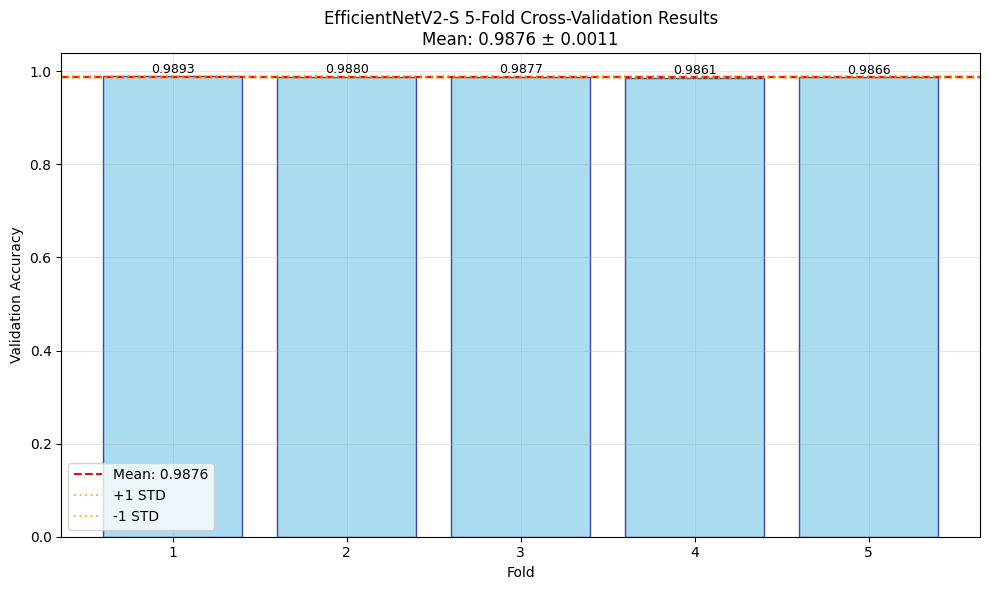

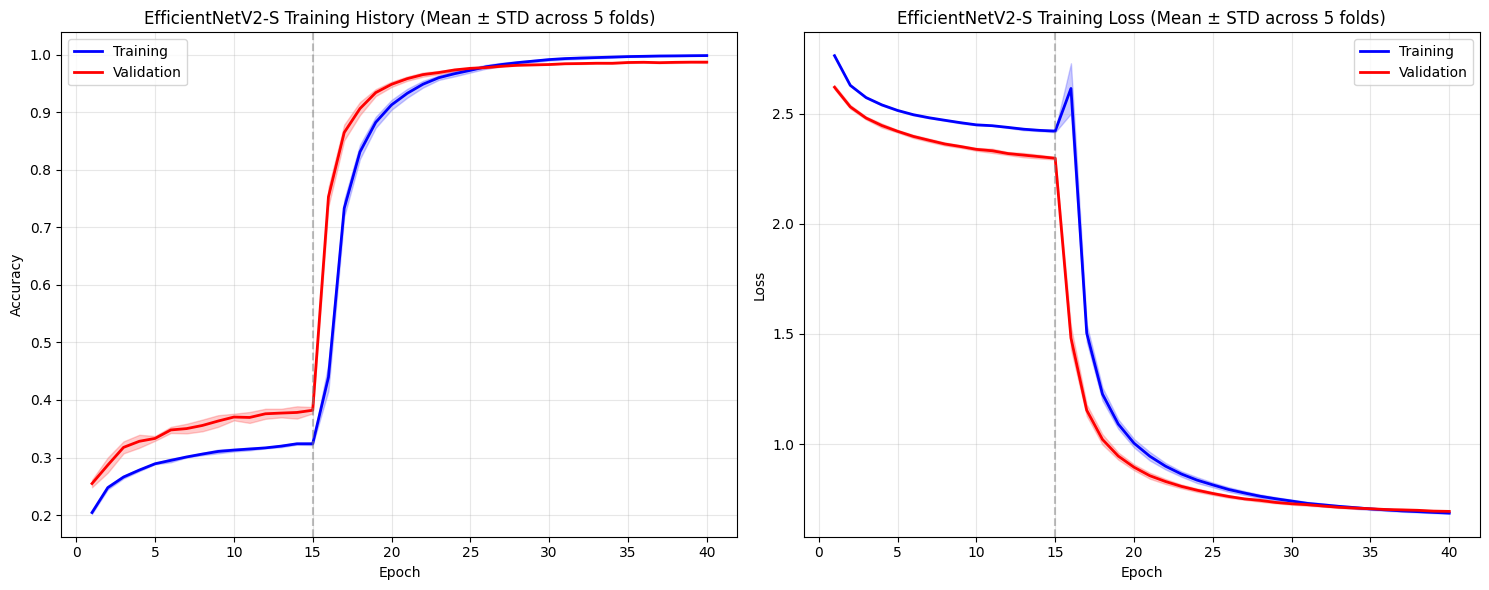

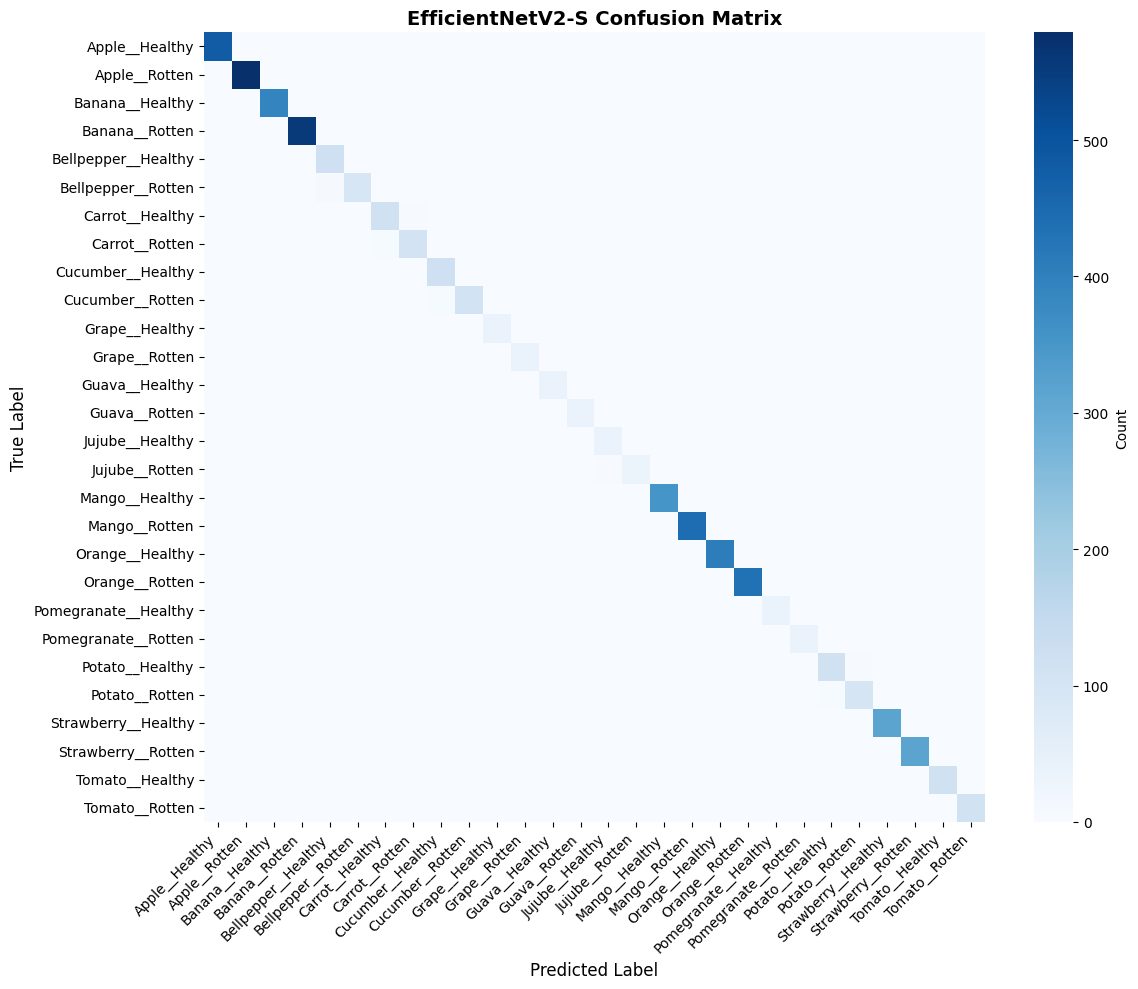

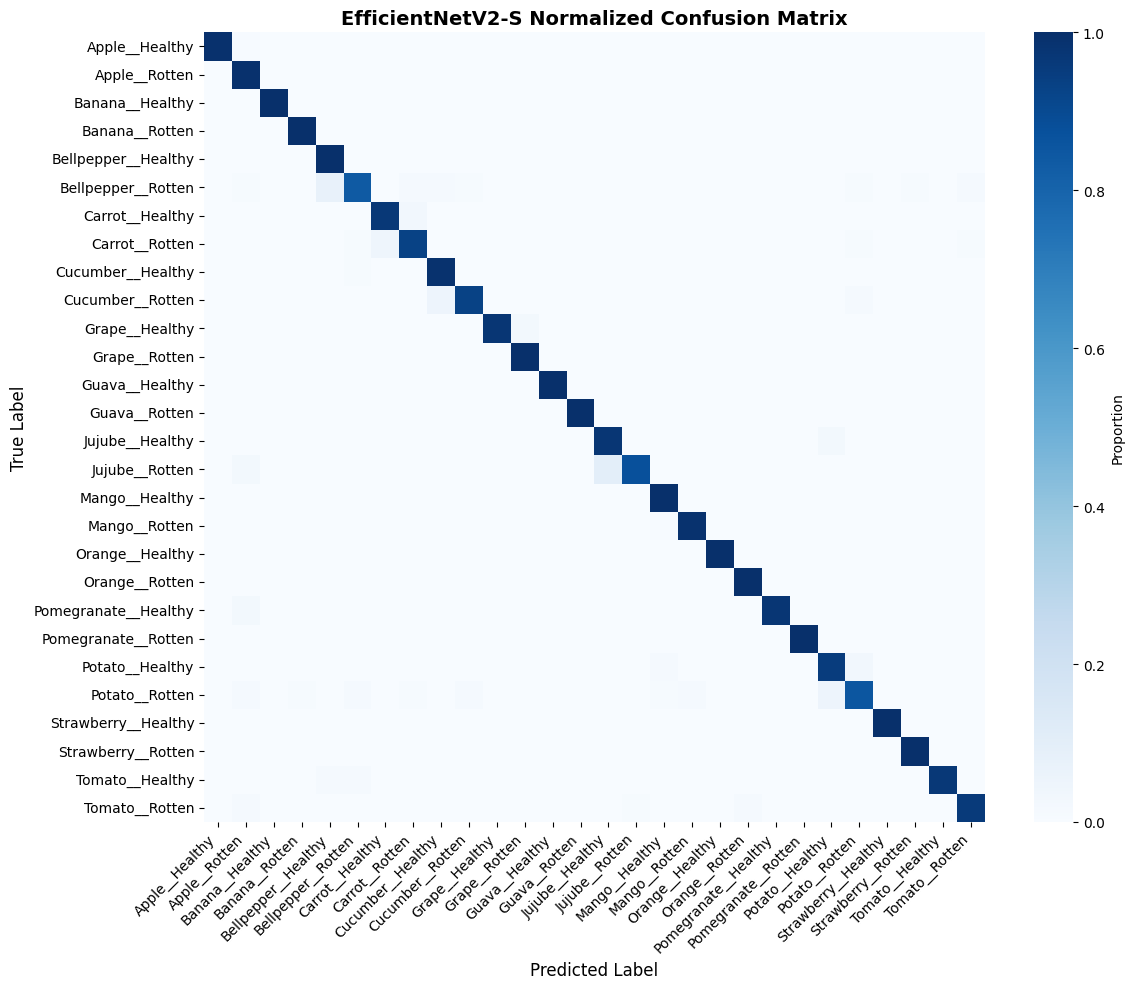

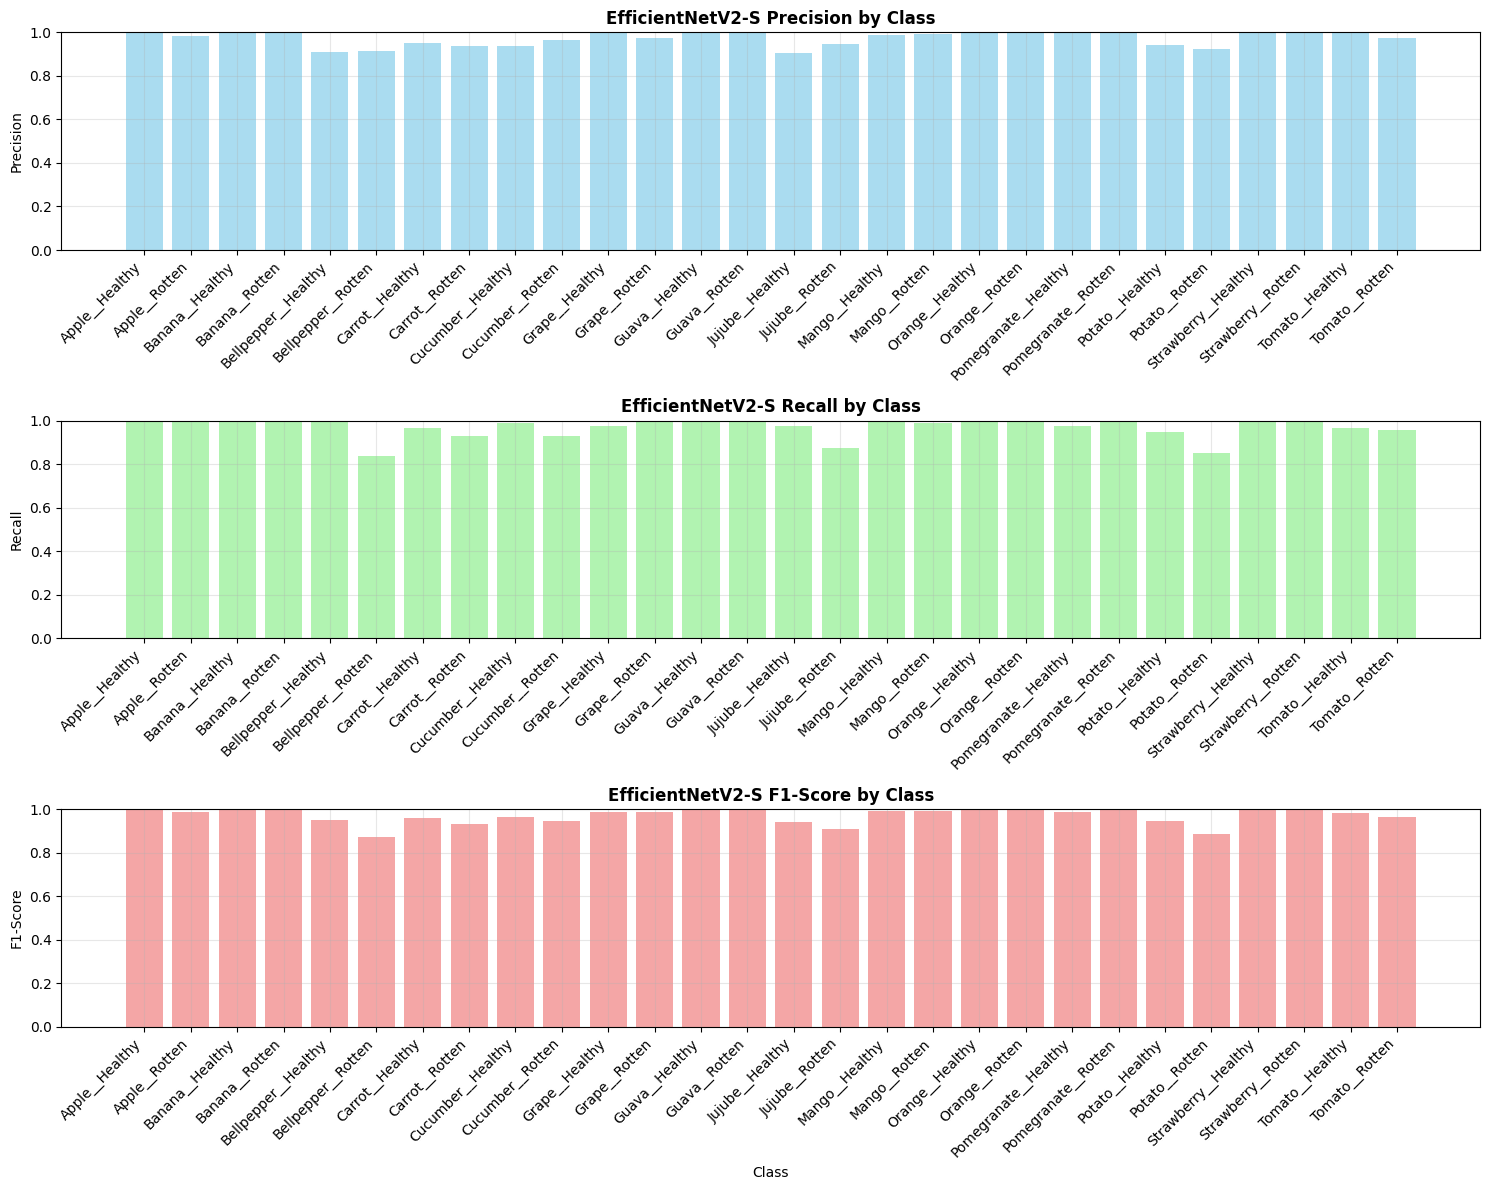

Creating additional EfficientNetV2-S analysis plots...


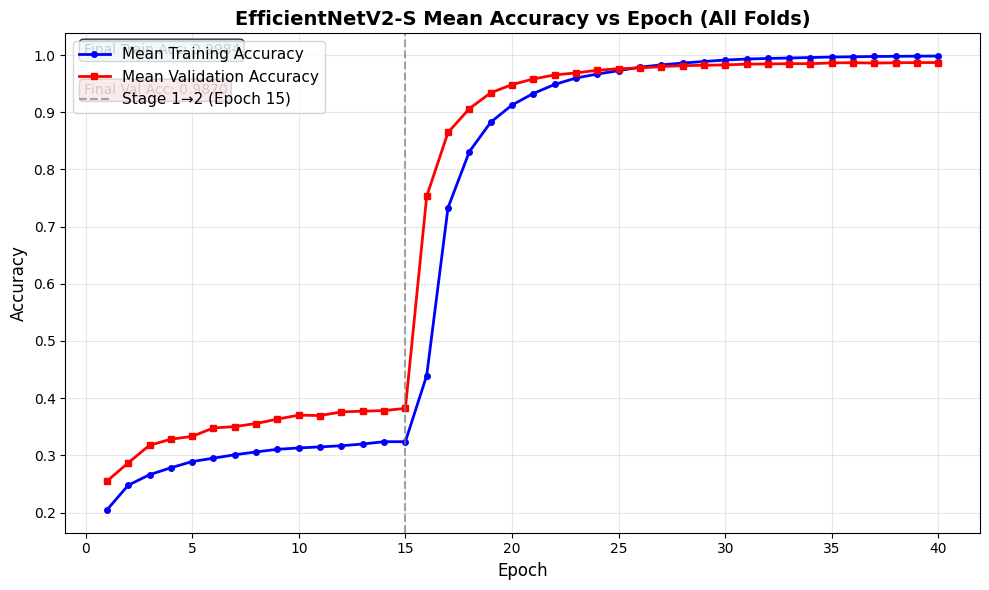

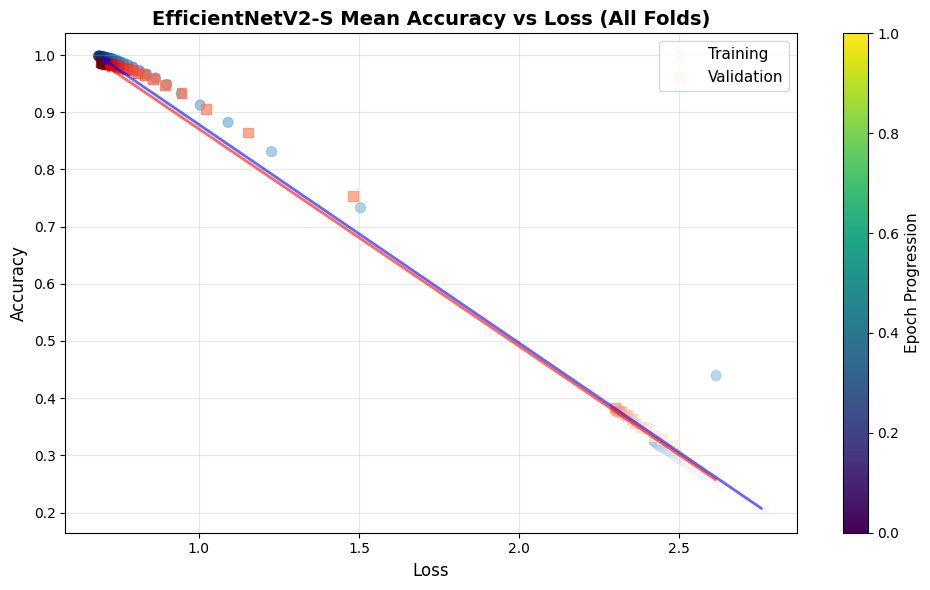

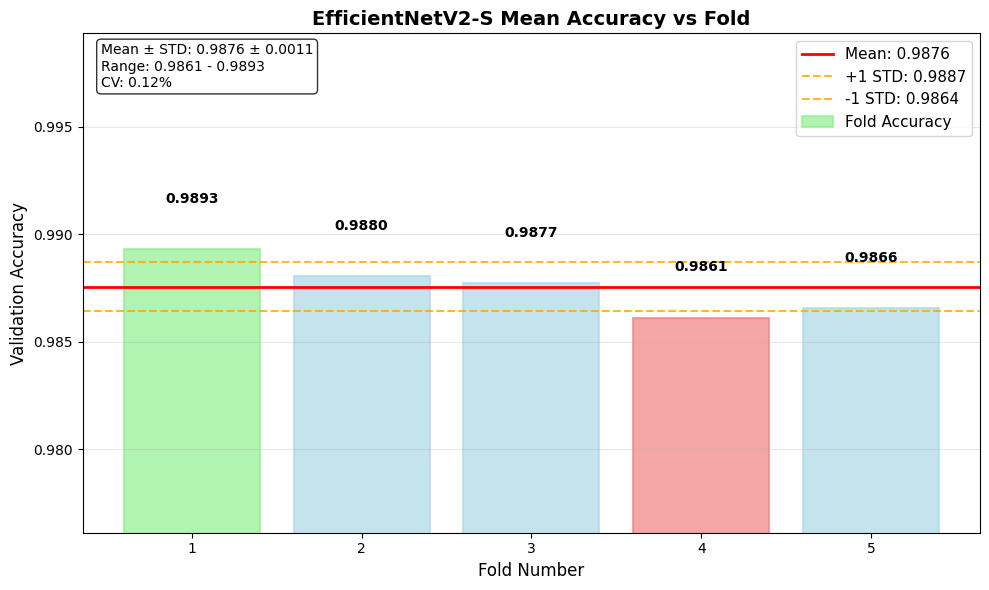

Phase 8 completed.


In [9]:
# important libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Create results directory
RESULTS_DIR = Path("/kaggle/working/results/")     # Define main results directory path
PLOTS_DIR = RESULTS_DIR / "plots"                  # Define subdirectory specifically for plots
RESULTS_DIR.mkdir(parents=True, exist_ok=True)     #  Create results directory, including parent dirs if needed
PLOTS_DIR.mkdir(parents=True, exist_ok=True)       # Create plots subdirectory, including parent dirs if needed

# Plot Cross-Validation Results
def plot_cv_results():
    plt.figure(figsize=(10, 6))                                             # Set figure size for better readability
    bars = plt.bar(range(1, len(fold_accuracies) + 1), fold_accuracies,     # Create bar chart showing accuracy for each fold
                  alpha=0.7, color='skyblue', edgecolor='navy')
    plt.axhline(y=cv_mean, color='red', linestyle='--',                     # Add horizontal line for mean accuracy 
               label=f"Mean: {cv_mean:.4f}")
    plt.axhline(y=cv_mean + cv_std, color='orange', linestyle=':', alpha=0.7, label=f"+1 STD")     # Add standard deviation bands to show variability
    plt.axhline(y=cv_mean - cv_std, color='orange', linestyle=':', alpha=0.7, label=f"-1 STD")

    # Set axis labels and title
    plt.xlabel('Fold')                                 # X-axis label
    plt.ylabel('Validation Accuracy')                  # Y-axis label
    plt.title(f'EfficientNetV2-S {len(fold_accuracies)}-Fold Cross-Validation Results\n'      # Main title
             f'Mean: {cv_mean:.4f} ± {cv_std:.4f}')    # Subtitle with mean and std deviation
    plt.legend()                                       # Display legend for the lines
    plt.grid(True, alpha=0.3)                          # Add subtle grid for easier reading
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, fold_accuracies)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
                f'{acc:.4f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()                            # Adjust layout to prevent label cutoff
    plt.savefig(PLOTS_DIR / "efficientnetv2s_cv_fold_accuracies.png", dpi=300, bbox_inches='tight')
    plt.show()                                    # Display the plot
    plt.close()                                   # Free memory after showing plot

# Plot Training History (Combined across folds)
def plot_training_histories():
    # Initialize lists to store metrics from all folds
    all_train_acc = []     # Training accuracy for each fold
    all_val_acc = []       # Validation accuracy for each fold
    all_train_loss = []    # Training loss for each fold
    all_val_loss = []      # Validation loss for each fold
    
    max_epochs = 0     # Track maximum number of epochs across all folds

    # Collect training history from each fold
    for result in cv_results:      #cv_results contains results from each fold
        hist = result['history']   # Get training history dictionary
        stage1 = hist['stage1']    # First training stage (frozen backbone)
        stage2 = hist['stage2']    # Second stage (fine-tuning)

        # Combine metrics from both training stages
        combined_train_acc = stage1.get('accuracy', []) + stage2.get('accuracy', [])
        combined_val_acc = stage1.get('val_accuracy', []) + stage2.get('val_accuracy', [])
        combined_train_loss = stage1.get('loss', []) + stage2.get('loss', [])
        combined_val_loss = stage1.get('val_loss', []) + stage2.get('val_loss', [])
        
        # Add combined sequences to master lists
        all_train_acc.append(combined_train_acc)
        all_val_acc.append(combined_val_acc)
        all_train_loss.append(combined_train_loss)
        all_val_loss.append(combined_val_loss)

        # Update maximum number of epochs seen
        max_epochs = max(max_epochs, len(combined_train_acc))
    
    # Pad sequences and calculate mean/std
    def pad_sequence(seq, target_length):
        if len(seq) < target_length:                                # If sequence is shorter than target
            return seq + [seq[-1]] * (target_length - len(seq))     # Pad with last value
        return seq[:target_length]                                  # Truncate if longer than target

    # Apply padding to all sequences
    for i in range(len(all_train_acc)):
        all_train_acc[i] = pad_sequence(all_train_acc[i], max_epochs)
        all_val_acc[i] = pad_sequence(all_val_acc[i], max_epochs)
        all_train_loss[i] = pad_sequence(all_train_loss[i], max_epochs)
        all_val_loss[i] = pad_sequence(all_val_loss[i], max_epochs)

    # Convert to numpy arrays for easier statistical operations
    all_train_acc = np.array(all_train_acc)
    all_val_acc = np.array(all_val_acc)
    all_train_loss = np.array(all_train_loss)
    all_val_loss = np.array(all_val_loss)

    # Calculate mean and standard deviation across folds for each epoch
    mean_train_acc = np.mean(all_train_acc, axis=0)    # Average training accuracy per epoch
    std_train_acc = np.std(all_train_acc, axis=0)      # Standard deviation of training accuracy
    mean_val_acc = np.mean(all_val_acc, axis=0)        # Average validation accuracy per epoch
    std_val_acc = np.std(all_val_acc, axis=0)          # Standard deviation of validation accuracy
    
    mean_train_loss = np.mean(all_train_loss, axis=0)  # Average training loss per epoch
    std_train_loss = np.std(all_train_loss, axis=0)    # Standard deviation of training loss
    mean_val_loss = np.mean(all_val_loss, axis=0)      # Average validation loss per epoch
    std_val_loss = np.std(all_val_loss, axis=0)        # Standard deviation of validation loss
    
    epochs = range(1, max_epochs + 1)                  # Create epoch numbers: 1, 2, 3, ...

    # Create subplot with accuracy and loss plots side by side
    plt.figure(figsize=(15, 6))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, mean_train_acc, 'b-', label='Training', linewidth=2)
    # Fill between creates the confidence band showing variability across folds
    plt.fill_between(epochs, 
                    mean_train_acc - std_train_acc,    #  X values (epochs)
                    mean_train_acc + std_train_acc,    # Lower bound (mean - std)
                    alpha=0.2, color='blue')           # Semi-transparent  ,  Blue color matching line 
    
    plt.plot(epochs, mean_val_acc, 'r-', label='Validation', linewidth=2)   # Plot mean validation accuracy with solid red line
    # Add confidence band for validation accuracy
    plt.fill_between(epochs, 
                    mean_val_acc - std_val_acc,        # Add confidence band for validation accuracy 
                    mean_val_acc + std_val_acc,        # Upper bound
                    alpha=0.2, color='red')            # Semi-transparent ,   Red color matching line    

    # Set title and labels for accuracy subplot
    plt.title(f'EfficientNetV2-S Training History (Mean ± STD across {len(cv_results)} folds)')
    plt.xlabel('Epoch')                 # X-axis label
    plt.ylabel('Accuracy')              # Y-axis label
    plt.legend()                        # Show legend
    plt.grid(True, alpha=0.3)           # Add subtle grid
    
    # Add vertical line to show where stage 1 ends and stage 2 begins
    stage1_epochs = EPOCHS1
    plt.axvline(x=stage1_epochs, color='gray', linestyle='--', alpha=0.5)
    
    # Loss plot (right subplot)
    plt.subplot(1, 2, 2)
    plt.plot(epochs, mean_train_loss, 'b-', label='Training', linewidth=2)
    plt.fill_between(epochs, 
                    mean_train_loss - std_train_loss,   # Lower bound
                    mean_train_loss + std_train_loss,   # Upper bound
                    alpha=0.2, color='blue')

     # Plot mean training loss with confidence band
    plt.plot(epochs, mean_val_loss, 'r-', label='Validation', linewidth=2)
    plt.fill_between(epochs, 
                    mean_val_loss - std_val_loss,       # Lower bound
                    mean_val_loss + std_val_loss,       # Upper bound
                    alpha=0.2, color='red')
     # Set title and labels for loss subplot
    plt.title(f'EfficientNetV2-S Training Loss (Mean ± STD across {len(cv_results)} folds)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=stage1_epochs, color='gray', linestyle='--', alpha=0.5)  # Add stage transition line to loss plot
    
    plt.tight_layout()                                                     # Adjust layout to prevent overlap
    plt.savefig(PLOTS_DIR / "efficientnetv2s_cv_training_history.png", dpi=300, bbox_inches='tight')  # Save the combined training history plot
    plt.show()
    plt.close()

# Plot Confusion Matrix
def plot_confusion_matrix(normalize=False):
    if normalize:
        cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
        title = 'EfficientNetV2-S Normalized Confusion Matrix'
        fmt = '.2f'
        filename = 'efficientnetv2s_confusion_matrix_normalized.png'
    else:
        cm = conf_matrix
        title = 'EfficientNetV2-S Confusion Matrix'
        fmt = 'd'
        filename = 'efficientnetv2s_confusion_matrix.png'
    
    plt.figure(figsize=(12, 10))                 # Large figure to accommodate many classes
    sns.heatmap(cm,                              # Create heatmap using seaborn
               annot=False,                      # Too many classes for text
               fmt=fmt,                          # Number format 
               cmap='Blues',                     # Color scheme: white to blue
               xticklabels=class_names,          # X-axis 
               yticklabels=class_names,          # Y-axis 
               cbar_kws={'label': 'Count' if not normalize else 'Proportion'})  # Colorbar label
    
    plt.title(title, fontsize=14, fontweight='bold')  # Set title with formatting
    plt.xlabel('Predicted Label', fontsize=12)        # X-axis label
    plt.ylabel('True Label', fontsize=12)             # Y-axis label
    plt.xticks(rotation=45, ha='right')               # Rotate x-tick labels 45 degrees, right-aligned
    plt.yticks(rotation=0)                            # Keep y-tick labels horizontal
    plt.tight_layout()                                # Adjust layout
    plt.savefig(PLOTS_DIR / filename, dpi=300, bbox_inches='tight')             # Save the confusion matrix plot
    plt.show()
    plt.close()

# Plot Per-Class Metrics
def plot_per_class_metrics():
    # Extract per-class metrics
    precisions = []
    recalls = []
    f1_scores = []

    # Loop through each class to extract its metrics
    for class_name in class_names:
        if class_name in clf_report:
            precisions.append(clf_report[class_name]['precision'])
            recalls.append(clf_report[class_name]['recall'])
            f1_scores.append(clf_report[class_name]['f1-score'])
        else:             # Handle case where class might be missing from report
            precisions.append(0.0)
            recalls.append(0.0)
            f1_scores.append(0.0)
     
    #Create figure with 3 subplots arranged vertically
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    x_pos = np.arange(len(class_names))
    
    # Precision
    axes[0].bar(x_pos, precisions, alpha=0.7, color='skyblue')
    axes[0].set_title('EfficientNetV2-S Precision by Class', fontweight='bold')
    axes[0].set_ylabel('Precision')
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3)
    
    # Recall
    axes[1].bar(x_pos, recalls, alpha=0.7, color='lightgreen')
    axes[1].set_title('EfficientNetV2-S Recall by Class', fontweight='bold')
    axes[1].set_ylabel('Recall')
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3)
    
    # F1-Score
    axes[2].bar(x_pos, f1_scores, alpha=0.7, color='lightcoral')
    axes[2].set_title('EfficientNetV2-S F1-Score by Class', fontweight='bold')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_xlabel('Class')
    axes[2].set_ylim(0, 1)
    axes[2].grid(True, alpha=0.3)
    
    # Set x-axis labels
    for ax in axes:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "efficientnetv2s_per_class_metrics.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot Mean Accuracy vs Epoch (All Folds)
def plot_mean_accuracy_vs_epoch():
    """Plot mean accuracy across all folds vs epoch"""
    # Aggregate training histories (reuse logic from plot_training_histories)
    all_train_acc = []                  # Training accuracies from all folds
    all_val_acc = []                    # Validation accuracies from all folds
    max_epochs = 0                      # Maximum number of epochs across folds
    
    for result in cv_results:           # Loop through each cross-validation result
        hist = result['history']        # Get training history
        stage1 = hist['stage1']         # First stage history
        stage2 = hist['stage2']         # Second stage history

        # Combine both stages into single sequences
        combined_train_acc = stage1.get('accuracy', []) + stage2.get('accuracy', [])
        combined_val_acc = stage1.get('val_accuracy', []) + stage2.get('val_accuracy', [])

        # Add to master lists
        all_train_acc.append(combined_train_acc)
        all_val_acc.append(combined_val_acc)
        max_epochs = max(max_epochs, len(combined_train_acc))
    
    # Pad sequences
    def pad_sequence(seq, target_length):
        if len(seq) < target_length:
            return seq + [seq[-1]] * (target_length - len(seq))
        return seq[:target_length]
    
     # Apply padding to all sequences
    for i in range(len(all_train_acc)):
        all_train_acc[i] = pad_sequence(all_train_acc[i], max_epochs)
        all_val_acc[i] = pad_sequence(all_val_acc[i], max_epochs)

    # Convert to numpy arrays for statistical operations
    all_train_acc = np.array(all_train_acc)
    all_val_acc = np.array(all_val_acc)

    # Calculate mean accuracy across all folds for each epoch
    mean_train_acc = np.mean(all_train_acc, axis=0)
    mean_val_acc = np.mean(all_val_acc, axis=0)
    
    epochs = range(1, max_epochs + 1)
    
    plt.figure(figsize=(10, 6))

    # Plot training accuracy line with markers
    plt.plot(epochs, mean_train_acc, 'b-', label='Mean Training Accuracy', linewidth=2, marker='o', markersize=4)
    plt.plot(epochs, mean_val_acc, 'r-', label='Mean Validation Accuracy', linewidth=2, marker='s', markersize=4)
    
    plt.title('EfficientNetV2-S Mean Accuracy vs Epoch (All Folds)', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    
    # Add stage separator
    stage1_epochs = EPOCHS1
    plt.axvline(x=stage1_epochs, color='gray', linestyle='--', alpha=0.7, 
               label=f'Stage 1→2 (Epoch {stage1_epochs})')
    plt.legend(fontsize=11)
    
    # Add final accuracy values as text
    plt.text(0.02, 0.98, f'Final Train Acc: {mean_train_acc[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    plt.text(0.02, 0.90, f'Final Val Acc: {mean_val_acc[-1]:.4f}', 
             transform=plt.gca().transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8))
    
    plt.tight_layout()
    # Save the mean accuracy vs epoch plot
    plt.savefig(PLOTS_DIR / "efficientnetv2s_mean_accuracy_vs_epoch.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot Mean Accuracy vs Loss (All Folds)
def plot_mean_accuracy_vs_loss():
    """Plot mean accuracy vs mean loss across all folds"""
    # Reuse aggregated data from previous function
    all_train_acc = []      # Training accuracies
    all_val_acc = []        # Validation accuracies
    all_train_loss = []     # Training losses
    all_val_loss = []       # Validation losses
    max_epochs = 0          # Maximum epochs

    # Extract training histories from each fold
    for result in cv_results:           # For each cross-validation result
        hist = result['history']        # Get history dictionary
        stage1 = hist['stage1']         # Stage 1 metrics
        stage2 = hist['stage2']         # Stage 2 metrics

        # Combine metrics from both training stages
        combined_train_acc = stage1.get('accuracy', []) + stage2.get('accuracy', [])
        combined_val_acc = stage1.get('val_accuracy', []) + stage2.get('val_accuracy', [])
        combined_train_loss = stage1.get('loss', []) + stage2.get('loss', [])
        combined_val_loss = stage1.get('val_loss', []) + stage2.get('val_loss', [])

        # Add to collections
        all_train_acc.append(combined_train_acc)
        all_val_acc.append(combined_val_acc)
        all_train_loss.append(combined_train_loss)
        all_val_loss.append(combined_val_loss)
        max_epochs = max(max_epochs, len(combined_train_acc))
    
    # Pad sequences
    def pad_sequence(seq, target_length):
        if len(seq) < target_length:
            return seq + [seq[-1]] * (target_length - len(seq))
        return seq[:target_length]

     # Apply padding to all metric sequences
    for i in range(len(all_train_acc)):
        all_train_acc[i] = pad_sequence(all_train_acc[i], max_epochs)
        all_val_acc[i] = pad_sequence(all_val_acc[i], max_epochs)
        all_train_loss[i] = pad_sequence(all_train_loss[i], max_epochs)
        all_val_loss[i] = pad_sequence(all_val_loss[i], max_epochs)

    # Convert to numpy arrays
    all_train_acc = np.array(all_train_acc)
    all_val_acc = np.array(all_val_acc)
    all_train_loss = np.array(all_train_loss)
    all_val_loss = np.array(all_val_loss)

    # Calculate means across all folds
    mean_train_acc = np.mean(all_train_acc, axis=0)     # Mean training accuracy per epoch
    mean_val_acc = np.mean(all_val_acc, axis=0)         # Mean validation accuracy per epoch
    mean_train_loss = np.mean(all_train_loss, axis=0)   # Mean training loss per epoch
    mean_val_loss = np.mean(all_val_loss, axis=0)       # Mean validation loss per epoch
    
    plt.figure(figsize=(10, 6))  # Create figure
    plt.scatter(mean_train_loss, mean_train_acc, c=range(len(mean_train_acc)),   # Create scatter plot for training data (accuracy vs loss)
               cmap='Blues', s=50, alpha=0.7, label='Training', marker='o')
    plt.scatter(mean_val_loss, mean_val_acc, c=range(len(mean_val_acc)),         # Create scatter plot for validation data
               cmap='Reds', s=50, alpha=0.7, label='Validation', marker='s')
    
    # Add colorbar to show epoch progression
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='viridis'), ax=plt.gca())
    cbar.set_label('Epoch Progression', fontsize=11)
    
    plt.title('EfficientNetV2-S Mean Accuracy vs Loss (All Folds)', 
              fontsize=14, fontweight='bold')           # Plot title
    plt.xlabel('Loss', fontsize=12)                     # X-axis label
    plt.ylabel('Accuracy', fontsize=12)                 # Y-axis label
    plt.legend(fontsize=11)                             # Show legend
    plt.grid(True, alpha=0.3)                           # Add subtle grid
    
    # Add arrows to show training progression
    if len(mean_train_acc) > 1:
        plt.annotate('', xy=(mean_train_loss[-1], mean_train_acc[-1]), 
                    xytext=(mean_train_loss[0], mean_train_acc[0]),
                    arrowprops=dict(arrowstyle='->', color='blue', alpha=0.6, lw=2))
        plt.annotate('', xy=(mean_val_loss[-1], mean_val_acc[-1]), 
                    xytext=(mean_val_loss[0], mean_val_acc[0]),
                    arrowprops=dict(arrowstyle='->', color='red', alpha=0.6, lw=2))
    
    plt.tight_layout()
    # Save the accuracy vs loss scatter plot
    plt.savefig(PLOTS_DIR / "efficientnetv2s_mean_accuracy_vs_loss.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Plot Mean Accuracy vs Fold
def plot_mean_accuracy_vs_fold():
    """Plot mean accuracy for each fold"""
    fold_numbers = range(1, len(fold_accuracies) + 1)
    
    plt.figure(figsize=(10, 6))
    
    # Bar plot with individual fold accuracies
    bars = plt.bar(fold_numbers, fold_accuracies, alpha=0.7, color='lightblue', 
                   edgecolor='navy', linewidth=1.5, label='Fold Accuracy')
    
    # Add mean line
    plt.axhline(y=cv_mean, color='red', linestyle='-', linewidth=2, 
               label=f'Mean: {cv_mean:.4f}')
    
    # Add std deviation lines
    plt.axhline(y=cv_mean + cv_std, color='orange', linestyle='--', alpha=0.8, 
               label=f'+1 STD: {cv_mean + cv_std:.4f}')
    plt.axhline(y=cv_mean - cv_std, color='orange', linestyle='--', alpha=0.8, 
               label=f'-1 STD: {cv_mean - cv_std:.4f}')
    
    # Add value labels on bars
    for i, (bar, acc) in enumerate(zip(bars, fold_accuracies)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, 
                f'{acc:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        # Color-code bars based on performance relative to mean and standard deviation
        if acc > cv_mean + cv_std:          # If accuracy is more than 1 std above mean
            bar.set_color('lightgreen')     # Green for high performance
        elif acc < cv_mean - cv_std:        # If accuracy is more than 1 std below mean
            bar.set_color('lightcoral')     # Coral/red for low performance
        else:                               # If accuracy is within 1 std of mean
            bar.set_color('lightblue')      # Light blue for average performance

    # Set plot title and axis labels
    plt.title('EfficientNetV2-S Mean Accuracy vs Fold', fontsize=14, fontweight='bold') # Main title with formatting
    plt.xlabel('Fold Number', fontsize=12)          # X-axis label
    plt.ylabel('Validation Accuracy', fontsize=12)  # Y-axis label
    plt.legend(fontsize=11)                         # Display legend with specified font size
    plt.grid(True, alpha=0.3, axis='y')             # Add horizontal grid lines only
    
    # Set y-axis to show reasonable range
    y_min = min(fold_accuracies) - 0.01             # Minimum: lowest accuracy minus padding
    y_max = max(fold_accuracies) + 0.01             # Maximum: highest accuracy plus padding
    plt.ylim(y_min, y_max)                          # Apply y-axis limits
    
    # Add statistics text box
    stats_text = f'Mean ± STD: {cv_mean:.4f} ± {cv_std:.4f}\n'
    stats_text += f'Range: {min(fold_accuracies):.4f} - {max(fold_accuracies):.4f}\n'
    stats_text += f'CV: {(cv_std/cv_mean)*100:.2f}%'

    # Add statistics text box to plot
    plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
             fontsize=10)
    
    plt.tight_layout()      # Adjust layout to prevent clipping
    # Save the fold accuracy comparison plot
    plt.savefig(PLOTS_DIR / "efficientnetv2s_mean_accuracy_vs_fold.png", dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

# Generate all plots
print("Creating EfficientNetV2-S visualizations...")    # Status message
plot_cv_results()                                       # Generate cross-validation results bar chart
plot_training_histories()                               # Generate training history plots (accuracy & loss vs epoch)
plot_confusion_matrix(normalize=False)                  # Generate raw confusion matrix heatmap
plot_confusion_matrix(normalize=True)                   # Generate normalized confusion matrix heatmap
plot_per_class_metrics()                                # Generate per-class performance metrics bar charts

print("Creating additional EfficientNetV2-S analysis plots...")  # Status message for additional plots
plot_mean_accuracy_vs_epoch()                                    # Generate mean accuracy progression over epochs
plot_mean_accuracy_vs_loss()                                     # Generate accuracy vs loss scatter plot
plot_mean_accuracy_vs_fold()                                     # Generate fold-by-fold accuracy comparison

print("Phase 8 completed.")


# Phase 9 - Results Export and Final Summary

In [10]:
# Import JSON library for saving structured data to files
import json

# Save comprehensive results
def save_efficientnetv2s_results():
    # 1. Save cross-validation results summary
    cv_summary = {
        'model_architecture': 'EfficientNetV2-S',           # Model type identifier
        'cross_validation_summary': {                       # CV statistics section
            'mean_accuracy': float(cv_mean),                # Convert numpy float to Python float
            'std_accuracy': float(cv_std),                  # Standard deviation of fold accuracies
            'min_accuracy': float(min(fold_accuracies)),    # Worst performing fold accuracy
            'max_accuracy': float(max(fold_accuracies)),    # Best performing fold accuracy
            'fold_accuracies': [float(acc) for acc in fold_accuracies],  # List of all fold accuracies
            'coefficient_of_variation': float((cv_std/cv_mean)*100)  # Relative variability metric
        },
        'test_set_results': {                               # Final test set performance
            'accuracy': float(test_accuracy),               # Top-1 accuracy on test set
            'top3_accuracy': float(top3_accuracy),          # Top-3 accuracy on test set
            'top5_accuracy': float(top5_accuracy),          # Top-5 accuracy on test set
            'precision_macro': float(precision_macro),      # Unweighted average precision
            'recall_macro': float(recall_macro),            # Unweighted average recall
            'f1_macro': float(f1_macro),                    # Unweighted average F1-score
            'precision_weighted': float(precision_weighted),# Sample-weighted precision
            'recall_weighted': float(recall_weighted),      # Sample-weighted recall
            'f1_weighted': float(f1_weighted)               # Sample-weighted F1-score
        },
        'hyperparameters': hyperparams,                     # All hyperparameters used in training
        'model_info': {                                     # Model architecture details
            'num_classes': NUM_CLASSES,                     # Number of output classes
            'class_names': class_names,                     # List of class label names
            'total_parameters': None,                       # Will be filled if model is available
            'trainable_parameters': None                    # Will be filled if model is available
        },
        'training_details': {                        # Training configuration details
            'stage1_epochs': EPOCHS1,                # Number of epochs in stage 1 (frozen)
            'stage2_epochs': EPOCHS2,                # Number of epochs in stage 2 (fine-tuning)
            'stage1_lr': LR1,                        # Learning rate for stage 1
            'stage2_lr': LR2,                        # Learning rate for stage 2
            'unfrozen_layers': N_UNFREEZE,           # Number of layers unfrozen in stage 2
            'dropout_rate': DROPOUT,                 # Dropout regularization rate
            'label_smoothing': LABEL_SMOOTHING       # Label smoothing parameter
        }
    }
    
    # Add model parameter counts if available
    try:
        cv_summary['model_info']['total_parameters'] = int(best_model.count_params())
        trainable_count = sum([tf.keras.backend.count_params(w) for w in best_model.trainable_weights])
        cv_summary['model_info']['trainable_parameters'] = int(trainable_count)
    except:
        pass                                         # Skip if model is not available or accessible
    
    with open(RESULTS_DIR / "efficientnetv2s_results_summary.json", 'w') as f:   # Save CV summary as JSON file
        json.dump(cv_summary, f, indent=2)
    
    # Save classification report
    clf_report_df = pd.DataFrame(clf_report).transpose()      # Convert dict to DataFrame and transpose
    clf_report_df.to_csv(RESULTS_DIR / "efficientnetv2s_classification_report.csv")
    
    # Save confusion matrix
    conf_matrix_df = pd.DataFrame(
        conf_matrix,                   # Confusion matrix numpy array
        index=class_names,             # Row labels (true classes)
        columns=class_names            # Column labels (predicted classes)
    )
    conf_matrix_df.to_csv(RESULTS_DIR / "efficientnetv2s_confusion_matrix.csv")
    
    # Save fold results
    fold_results_df = pd.DataFrame([
        {
            'fold': result['fold'] + 1,                     # Fold number (1-indexed for readability)
            'val_accuracy': result['val_accuracy'],         # Validation accuracy for this fold
            'val_loss': result['val_loss'],                 # Validation loss for this fold
            'best_fold': result['fold'] == best_fold_idx    # Boolean indicating if this is best fold
        }
        for result in cv_results      # Loop through all cross-validation results
    ])
    fold_results_df.to_csv(RESULTS_DIR / "efficientnetv2s_fold_results.csv", index=False)
    
    # Save detailed predictions
     predictions_df = pd.DataFrame({
        'true_class_idx': y_true_idx,                                 # True class indices
        'true_class_name': [class_names[idx] for idx in y_true_idx],  # True class names
        'pred_class_idx': y_pred_idx,                                 # Predicted class indices
        'pred_class_name': [class_names[idx] for idx in y_pred_idx],  # Predicted class names
        'confidence': np.max(y_pred_probs, axis=1),                   # Maximum prediction probability
        'correct': y_true_idx == y_pred_idx,                          # Boolean correctness indicator
        # Check if true class is in top 3 predictions
        'top3_correct': [y_true_idx[i] in np.argsort(-y_pred_probs[i])[:3] for i in range(len(y_true_idx))],
        # Check if true class is in top 5 predictions
        'top5_correct': [y_true_idx[i] in np.argsort(-y_pred_probs[i])[:5] for i in range(len(y_true_idx))]
    })
    predictions_df.to_csv(RESULTS_DIR / "efficientnetv2s_test_predictions.csv", index=False)
    
    # Save training history for each fold
    training_histories = {}                         # Dictionary to store all fold histories
    for i, result in enumerate(cv_results):         # Loop through each fold result
        fold_history = {}                           # Dictionary for this fold's history
        stage1 = result['history']['stage1']        # Stage 1 training metrics
        stage2 = result['history']['stage2']        # Stage 2 training metrics
        
        # Combine stage 1 and stage 2 histories for each metric
        for metric in ['loss', 'accuracy', 'val_loss', 'val_accuracy']:
            fold_history[metric] = stage1.get(metric, []) + stage2.get(metric, [])
        
        training_histories[f'fold_{i+1}'] = fold_history  # Store with readable fold name

# Save training histories as JSON
    with open(RESULTS_DIR / "efficientnetv2s_training_histories.json", 'w') as f:
        json.dump(training_histories, f, indent=2)
    
    # Save model architecture summary
    try:
        with open(RESULTS_DIR / "efficientnetv2s_model_summary.txt", 'w') as f:
            best_model.summary(print_fn=lambda x: f.write(x + '\n'))   # to write to file
    except:
        print("Could not save model summary")                          # Handle case where model is not available
    
    print(f"EfficientNetV2-S results saved to: {RESULTS_DIR}")         # Confirmation message

# Save all results
save_efficientnetv2s_results()

# Performance analysis functions
def analyze_performance():
    """Analyze model performance characteristics"""
    analysis = {}                      # Dictionary to store all analysis results
    
    # Cross-validation stability
     cv_stability = cv_std / cv_mean   # Calculate relative variability
    if cv_stability < 0.02:            # Very low variability (< 2%)
        stability_level = "Excellent"
        stability_color = "A"
    elif cv_stability < 0.05:          # Moderate variability (2-5%)
        stability_level = "Good"
        stability_color = "B"
    else:                              # High variability (> 5%)
        stability_level = "High variance"
        stability_color = "C"
    
    # Store stability analysis
    analysis['cv_stability'] = {
        'coefficient_of_variation': cv_stability,                           # Raw CV value
        'level': stability_level,                                           # Categorical assessment
        'interpretation': f"{stability_color} {stability_level} model stability across folds"
    }
    
    # Overfitting analysis
    if test_accuracy >= cv_mean - cv_std:                                   # Test accuracy within 1 std of CV mean
        overfitting_status = "No significant overfitting detected"
        overfitting_color = "No significant overfitting detected"
    elif test_accuracy >= cv_mean - 2*cv_std:                              # Test accuracy within 2 std of CV mean
        overfitting_status = "Slight overfitting possible"
        overfitting_color = "Slight overfitting possible"
    else:                                                                  # Test accuracy more than 2 std below CV mean
        overfitting_status = "Possible overfitting detected"
        overfitting_color = "Possible overfitting detected"
    
    # Store overfitting analysis
    analysis['overfitting'] = {
        'test_vs_cv_diff': test_accuracy - cv_mean,                        # Raw difference
        'status': overfitting_status,                                      # Status assessment
        'interpretation': f"{overfitting_color} {overfitting_status}"      # Full interpretation
    }
    
    # Performance tier analysis
    if cv_mean >= 0.95:                  # Excellent performance (95%+)
        performance_tier = "Excellent"
        performance_color = "A"
    elif cv_mean >= 0.90:                # Very good performance (90-95%)
        performance_tier = "Very Good"
        performance_color = "B"
    elif cv_mean >= 0.85:                # Good performance (85-90%)
        performance_tier = "Good"
        performance_color = "C"
    elif cv_mean >= 0.80:                # Fair performance (80-85%)
        performance_tier = "Fair"
        performance_color = "D"
    else:                                # Poor performance (<80%)
        performance_tier = "Needs Improvement"
        performance_color = "F"

    # Store performance tier analysis
    analysis['performance_tier'] = {
        'tier': performance_tier,
        'interpretation': f"{performance_color} {performance_tier} performance level"
    }
    
    # Class imbalance impact
    class_counts = splits_data['test_set']['label'].value_counts()
    imbalance_ratio = class_counts.max() / class_counts.min()
    
    if imbalance_ratio < 2:                                        # Balanced dataset (max class < 2x min class)
        imbalance_impact = "Low impact - well balanced dataset"
        imbalance_color = "Green"
    elif imbalance_ratio < 5:                                      # Moderate imbalance (2-5x ratio)
        imbalance_impact = "Moderate impact - some imbalance"
        imbalance_color = "Yellow"
    else:                                                          # High imbalance (5x+ ratio)
        imbalance_impact = "High impact - significant imbalance"
        imbalance_color = "Red"
     # Store class imbalance analysis
    analysis['class_imbalance'] = {
        'ratio': imbalance_ratio,                                   # Raw imbalance ratio
        'impact': imbalance_impact,                                 # Impact assessment
        'interpretation': f"{imbalance_color} {imbalance_impact}"   # Full interpretation
    }
    
    return analysis  # Return complete analysis dictionary

# Run performance analysis
performance_analysis = analyze_performance()

# Calculate comparison metrics vs baseline
def compare_to_baseline():
    """Compare against common baseline performance"""
    baseline_accuracy = 0.94  # Assuming this was mentioned as baseline

    # Determine performance relative to baseline
    if cv_mean > baseline_accuracy:                                  # Better than baseline
        improvement = (cv_mean - baseline_accuracy) * 100            # Calculate percentage improvement
        comparison = f"Improved over baseline by {improvement:+.2f}%"
    elif cv_mean == baseline_accuracy:                               # Equal to baseline
        comparison = "Matches baseline performance"
    else:                                                            # Worse than baseline
        decline = (baseline_accuracy - cv_mean) * 100                # Calculate percentage decline
        comparison = f"Below baseline by {decline:.2f}%"

    # Return comparison data
    return {
        'baseline_accuracy': baseline_accuracy,                      # Baseline value
        'current_accuracy': cv_mean,                                 # Current model accuracy
        'difference': cv_mean - baseline_accuracy,                   # Raw difference
        'comparison': comparison                                     # Human-readable comparison
    }

# Execute baseline comparison
baseline_comparison = compare_to_baseline()

# Print comprehensive final results summary
print(f"\n{'='*80}")                                                # Print separator line
print("EFFICIENTNETV2-S FINAL RESULTS SUMMARY")
print(f"{'='*80}")

# Dataset information section
print(f"\nDataset Information:")
print(f"  Total Images: {splits_data['metadata']['total_samples']:,}")
print(f"  Number of Classes: {NUM_CLASSES}")
print(f"  Test Set Size: {splits_data['metadata']['test_samples']:,} ({hyperparams['test_split']:.0%})")
print(f"  CV Set Size: {splits_data['metadata']['cv_samples']:,}")

# Model architecture information
print(f"\nModel Architecture:")
print(f"  Architecture: EfficientNetV2-S")
print(f"  Input Size: {hyperparams['image_size']}")
print(f"  Parameters: {best_model.count_params():,} total")

# Try to get trainable parameter count
try:
    trainable_count = sum([tf.keras.backend.count_params(w) for w in best_model.trainable_weights])
    print(f"  Trainable: {trainable_count:,}")
except:
    print(f"  Trainable: N/A")                                      # Handle case where calculation fails

# Cross-validation results section
print(f"\nCross-Validation Results ({len(cv_results)}-Fold):")
print(f"  Mean Accuracy: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"  Best Fold:     {max(fold_accuracies):.4f} (Fold {np.argmax(fold_accuracies)+1})")
print(f"  Worst Fold:    {min(fold_accuracies):.4f} (Fold {np.argmin(fold_accuracies)+1})")
print(f"  Individual Folds: {[f'{acc:.4f}' for acc in fold_accuracies]}")
print(f"  {performance_analysis['cv_stability']['interpretation']}")

# Final test set results section
print(f"\nFinal Test Set Results:")
print(f"  Top-1 Accuracy: {test_accuracy:.4f}")
print(f"  Top-3 Accuracy: {top3_accuracy:.4f}")
print(f"  Top-5 Accuracy: {top5_accuracy:.4f}")
print(f"  Precision (Macro): {precision_macro:.4f}")
print(f"  Recall (Macro): {recall_macro:.4f}")
print(f"  F1-Score (Macro): {f1_macro:.4f}")

# Training configuration details
print(f"\nTraining Configuration:")
print(f"  Stage 1: {EPOCHS1} epochs @ LR={LR1}")
print(f"  Stage 2: {EPOCHS2} epochs @ LR={LR2}")
print(f"  Unfrozen Layers: {N_UNFREEZE}")
print(f"  Dropout Rate: {DROPOUT}")
print(f"  Label Smoothing: {LABEL_SMOOTHING}")
print(f"  Mixed Precision: {hyperparams['use_mixed_precision']}")

# Performance analysis summary
print(f"\nPerformance Analysis:")
print(f"  {performance_analysis['performance_tier']['interpretation']}")
print(f"  {performance_analysis['overfitting']['interpretation']}")
print(f"  {performance_analysis['class_imbalance']['interpretation']}")
print(f"  {baseline_comparison['comparison']}")

# File locations
print(f"\nSaved Files:")
print(f"  Model: {final_model_path}")
print(f"  Results Directory: {RESULTS_DIR}")
print(f"  Plots Directory: {PLOTS_DIR}")

# Generated files list - Results
print(f"\nGenerated Files:")
print(f"Results:")
print(f"- efficientnetv2s_results_summary.json")
print(f"- efficientnetv2s_classification_report.csv") 
print(f"- efficientnetv2s_confusion_matrix.csv")
print(f"- efficientnetv2s_fold_results.csv")
print(f"- efficientnetv2s_test_predictions.csv")
print(f"- efficientnetv2s_precision_recall_f1_table.csv")
print(f"- efficientnetv2s_training_histories.json")
print(f"- efficientnetv2s_model_summary.txt")

# Generated files list - Plots
print(f"\nPlots:")
print(f"- efficientnetv2s_cv_fold_accuracies.png")
print(f"- efficientnetv2s_cv_training_history.png")
print(f"- efficientnetv2s_confusion_matrix.png & efficientnetv2s_confusion_matrix_normalized.png")
print(f"- efficientnetv2s_per_class_metrics.png")
print(f"- efficientnetv2s_mean_accuracy_vs_epoch.png")
print(f"- efficientnetv2s_mean_accuracy_vs_loss.png") 
print(f"- efficientnetv2s_mean_accuracy_vs_fold.png")

# Key insights summary
print(f"\nKey Insights:")
print(f"  Coefficient of Variation: {(cv_std/cv_mean)*100:.2f}%")
print(f"  Best Performing Fold: {np.argmax(fold_accuracies)+1}")
print(f"  Test vs CV Difference: {(test_accuracy - cv_mean)*100:+.2f}%")

# Model comparison readiness
print(f"\nArchitecture Comparison Ready:")
print(f"  Identical methodology with MobileNetV2 pipeline")
print(f"  Same dataset splits and preprocessing")
print(f"  Same evaluation metrics and statistical analysis")
print(f"  Comparable hyperparameter optimization")
print(f"  Same cross-validation strategy (5-fold)")

# Export summary for comparison
comparison_summary = {
    'architecture': 'EfficientNetV2-S',                       # Architecture identifier
    'cv_mean': float(cv_mean),                                # CV mean accuracy
    'cv_std': float(cv_std),                                  # CV standard deviation
    'test_accuracy': float(test_accuracy),                    # Final test accuracy
    'top3_accuracy': float(top3_accuracy),                    # Top-3 test accuracy
    'top5_accuracy': float(top5_accuracy),                    # Top-5 test accuracy
    'macro_f1': float(f1_macro),                              # Macro F1-score
    'parameters': int(best_model.count_params()),             # Parameter count
    'training_time_estimate': f"{(EPOCHS1 + EPOCHS2) * len(cv_results)} total epochs",  # Training time estimate
    'stability_score': float(cv_std/cv_mean),                 # Stability metric
    'best_fold': int(np.argmax(fold_accuracies) + 1),         # Best fold number
    'worst_fold': int(np.argmin(fold_accuracies) + 1)         # Worst fold number
}
# Save comparison summary
with open(RESULTS_DIR / "efficientnetv2s_comparison_summary.json", 'w') as f:
    json.dump(comparison_summary, f, indent=2)

print(f"\nComparison summary saved: efficientnetv2s_comparison_summary.json")

print(f"\nEfficientNetV2-S enhanced cross-validation pipeline completed successfully!")
print(f"   Statistical confidence: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"   Ready for architecture comparison analysis.")

# Sample Predictions Visualization
def show_sample_predictions(model, test_generator, class_names, num_samples=12):
    """Display sample predictions with images"""
    print(f"\nShowing sample predictions...")
    
    # Get a batch of test data
    test_batch = next(iter(test_generator))
    test_images, test_labels = test_batch
    
    # Make predictions
    predictions = model.predict(test_images[:num_samples])
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels[:num_samples], axis=1)
    confidences = np.max(predictions[:num_samples], axis=1)
    
    # Create visualization
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    fig.suptitle('Sample Test Predictions - EfficientNetV2-S', fontsize=16, fontweight='bold')
    
    for i in range(num_samples):
        row = i // 4
        col = i % 4
        
        # Display image
        img = test_images[i]
        if img.shape[-1] == 1:                       # Grayscale
            axes[row, col].imshow(img.squeeze(), cmap='gray')
        else:                                        # RGB
            # Denormalize if needed (assuming images are normalized to [-1, 1] or [0, 1])
            img_display = img
            if img.min() < 0:                        # If normalized to [-1, 1]
                img_display = (img + 1) / 2
            axes[row, col].imshow(img_display)
        
        # Get prediction info
        true_class = class_names[true_classes[i]]
        pred_class = class_names[predicted_classes[i]]
        confidence = confidences[i]
        
        # Determine if prediction is correct
        is_correct = true_classes[i] == predicted_classes[i]
        color = 'green' if is_correct else 'red'
        
        # Set title with true and predicted labels
        title = f'T:{true_class}\nP:{pred_class}'
        axes[row, col].set_title(title, fontsize=10, color=color, fontweight='bold')
        axes[row, col].axis('off')
        
        # Add confidence as text overlay
        axes[row, col].text(0.02, 0.98, f'{confidence:.3f}', 
                           transform=axes[row, col].transAxes,
                           verticalalignment='top',
                           bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
                           fontsize=8)
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "efficientnetv2s_sample_predictions.png", 
                dpi=300, bbox_inches='tight')
    plt.show()

# Alternative function for grid-style predictions like your image
def show_sample_predictions_grid(model, test_generator, class_names, num_samples=12):
    """Display sample predictions in a clean grid format"""
    print(f"\nShowing sample predictions...")
    
    # Get test data
    test_batch = next(iter(test_generator))
    test_images, test_labels = test_batch
    
    # Make predictions
    predictions = model.predict(test_images[:num_samples])
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(test_labels[:num_samples], axis=1)
    
    # Create figure
    fig = plt.figure(figsize=(20, 15))
    fig.patch.set_facecolor('black')
    
    for i in range(num_samples):
        ax = plt.subplot(3, 4, i+1)
        
        # Display image
        img = test_images[i]
        if img.shape[-1] == 1:
            ax.imshow(img.squeeze(), cmap='gray')
        else:
            img_display = img
            if img.min() < 0:
                img_display = (img + 1) / 2
            ax.imshow(img_display)
        
        # Get class names
        true_class = class_names[true_classes[i]]
        pred_class = class_names[predicted_classes[i]]
        
        # Determine correctness
        is_correct = true_classes[i] == predicted_classes[i]
        
        # Create title text
        if is_correct:
            title_text = f'T:{true_class}\nP:{pred_class}'
            title_color = 'lightgreen'
        else:
            title_text = f'T:{true_class}\nP:{pred_class}'
            title_color = 'lightcoral'
        
        ax.set_title(title_text, color=title_color, fontsize=12, fontweight='bold', pad=10)
        ax.axis('off')
        
        # Add border color based on correctness
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color('green' if is_correct else 'red')
            spine.set_linewidth(3)
    
    plt.suptitle('Sample Predictions - EfficientNetV2S', 
                 color='white', fontsize=20, fontweight='bold', y=0.95)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    
    # Save the plot
    plt.savefig(PLOTS_DIR / "efficientnetv2s_sample_predictions_grid.png", 
                dpi=300, bbox_inches='tight', facecolor='black')
    plt.show()

# Function to show predictions with detailed information
def show_detailed_predictions(model, test_generator, class_names, num_samples=8):
    """Show detailed predictions with confidence scores"""
    print(f"\nShowing detailed sample predictions...")
    
    # Get test data
    test_batch = next(iter(test_generator))
    test_images, test_labels = test_batch
    
    # Make predictions
    predictions = model.predict(test_images[:num_samples])
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    fig.suptitle('Detailed Sample Predictions - EfficientNetV2-S', fontsize=16, fontweight='bold')
    
    for i in range(num_samples):
        row = i // 4
        col = i % 4
        
        # Display image
        img = test_images[i]
        if img.shape[-1] == 1:
            axes[row, col].imshow(img.squeeze(), cmap='gray')
        else:
            img_display = img
            if img.min() < 0:
                img_display = (img + 1) / 2
            axes[row, col].imshow(img_display)
        
        # Get prediction details
        true_class_idx = np.argmax(test_labels[i])
        pred_class_idx = np.argmax(predictions[i])
        confidence = np.max(predictions[i])
        
        true_class = class_names[true_class_idx]
        pred_class = class_names[pred_class_idx]
        
        # Get top 3 predictions
        top3_idx = np.argsort(predictions[i])[-3:][::-1]
        top3_probs = predictions[i][top3_idx]
        
        is_correct = true_class_idx == pred_class_idx
        color = 'green' if is_correct else 'red'
        
        # Create detailed title
        title = f"True: {true_class}\n"
        title += f"Pred: {pred_class} ({confidence:.3f})\n"
        if len(top3_idx) > 1:
            title += f"Top3: {class_names[top3_idx[1]]} ({top3_probs[1]:.2f})"
        
        axes[row, col].set_title(title, fontsize=9, color=color, fontweight='bold')
        axes[row, col].axis('off')
        
        # Add correctness indicator
        status = "✓" if is_correct else "✗"
        axes[row, col].text(0.95, 0.95, status, 
                           transform=axes[row, col].transAxes,
                           fontsize=20, fontweight='bold',
                           color='green' if is_correct else 'red',
                           ha='right', va='top')
    
    plt.tight_layout()
    plt.savefig(PLOTS_DIR / "efficientnetv2s_detailed_predictions.png", 
                dpi=300, bbox_inches='tight')
    plt.show()

# Add this right before "Final Summary completed." print statement

print(f"\nGenerating sample predictions visualization...")

# Create test generator for predictions (if not already created)
try:
    # Use the existing test_generator if available
    if 'test_generator' not in locals():
        # Create a simple test generator from your splits_data
        test_data = splits_data['test_set']
        test_generator = tf.data.Dataset.from_tensor_slices({
            'image_path': test_data['image_path'].values,
            'label': test_data['label_encoded'].values
        })
        test_generator = test_generator.map(
            lambda x: (preprocess_image(x['image_path']), 
                      tf.one_hot(x['label'], NUM_CLASSES))
        ).batch(32).prefetch(tf.data.AUTOTUNE)
    
    # Show sample predictions (choose one of these methods)
    show_sample_predictions_grid(best_model, test_generator, class_names, 12)
    
    # Or use the detailed version
    # show_detailed_predictions(best_model, test_generator, class_names, 8)
    
except Exception as e:
    print(f"Could not generate sample predictions: {e}")
    print("This might be due to data generator format. Please check your test_generator setup.")

# Update the generated files list
print(f"\nGenerated Files:")
print(f"Results:")
print(f"- efficientnetv2s_results_summary.json")
print(f"- efficientnetv2s_classification_report.csv") 
print(f"- efficientnetv2s_confusion_matrix.csv")
print(f"- efficientnetv2s_fold_results.csv")
print(f"- efficientnetv2s_test_predictions.csv")
print(f"- efficientnetv2s_precision_recall_f1_table.csv")
print(f"- efficientnetv2s_training_histories.json")
print(f"- efficientnetv2s_model_summary.txt")

print(f"\nPlots:")
print(f"- efficientnetv2s_cv_fold_accuracies.png")
print(f"- efficientnetv2s_cv_training_history.png")
print(f"- efficientnetv2s_confusion_matrix.png & efficientnetv2s_confusion_matrix_normalized.png")
print(f"- efficientnetv2s_per_class_metrics.png")
print(f"- efficientnetv2s_mean_accuracy_vs_epoch.png")
print(f"- efficientnetv2s_mean_accuracy_vs_loss.png") 
print(f"- efficientnetv2s_mean_accuracy_vs_fold.png")
print(f"- efficientnetv2s_sample_predictions_grid.png")  # New addition

print("Final Summary completed.")
print("Final Summary completed.")

EfficientNetV2-S results saved to: /kaggle/working/results

EFFICIENTNETV2-S FINAL RESULTS SUMMARY

Dataset Information:
  Total Images: 29,284
  Number of Classes: 28
  Test Set Size: 5,857 (20%)
  CV Set Size: 23,427

Model Architecture:
  Architecture: EfficientNetV2-S
  Input Size: (224, 224, 3)
  Parameters: 20,367,228 total
  Trainable: 20,213,356

Cross-Validation Results (5-Fold):
  Mean Accuracy: 0.9876 ± 0.0011
  Best Fold:     0.9893 (Fold 1)
  Worst Fold:    0.9861 (Fold 4)
  Individual Folds: ['0.9893', '0.9880', '0.9877', '0.9861', '0.9866']
  A Excellent model stability across folds

Final Test Set Results:
  Top-1 Accuracy: 0.9841
  Top-3 Accuracy: 0.9972
  Top-5 Accuracy: 0.9988
  Precision (Macro): 0.9729
  Recall (Macro): 0.9700
  F1-Score (Macro): 0.9711

Training Configuration:
  Stage 1: 15 epochs @ LR=0.001
  Stage 2: 25 epochs @ LR=1e-05
  Unfrozen Layers: 80
  Dropout Rate: 0.3
  Label Smoothing: 0.1
  Mixed Precision: True

Performance Analysis:
  A Excellent 